# 🧠 Deep Sector Rotation Swing Trading Notebook

This notebook implements a weekly ETF sector rotation strategy inspired by the paper:

**"Deep Sector Rotation Swing Trading"** (Bock & Maewal, SSRN #4280640)

---

### 📌 Strategy Summary:
- Trades once per week (Buy on Monday open, Sell on Friday close)
- Uses a deep learning model to predict next-week returns for selected ETFs
- Selects high-confidence trades using Monte Carlo Dropout
- Allocates capital selectively based on prediction strength

---

### 🔧 Key Components:
- Weekly ETF price data (e.g., XLK, XLF, XLV…)
- Rolling technical and macro features
- Multi-output regression model
- Weekly backtest with position logging and performance metrics


In [388]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# ETF list
etf_list = [
    'XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS'
]

# Date range
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(weeks=5*52)).strftime('%Y-%m-%d')

print(f"📅 Downloading data from {start_date} to {end_date}")

# Ensure dataset/ exists
dataset_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
if not os.path.isdir(dataset_path):
    raise FileNotFoundError(f"🚫 'dataset/' folder not found at {dataset_path}")

# Containers
adjclose_data, volume_data, high_data, low_data = {}, {}, {}, {}

# Download each ETF
for symbol in etf_list:
    print(f"⬇️ Downloading {symbol}...")
    data = yf.download(symbol, start=start_date, end=end_date, interval='1wk', auto_adjust=False)
    if not data.empty:
        adjclose_data[symbol] = data[['Adj Close']].rename(columns={'Adj Close': symbol})
        volume_data[symbol] = data[['Volume']].rename(columns={'Volume': symbol})
        high_data[symbol] = data[['High']].rename(columns={'High': symbol})
        low_data[symbol] = data[['Low']].rename(columns={'Low': symbol})

# Merge and clean
def combine_and_save(data_dict, filename):
    df = pd.concat(data_dict.values(), axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df.dropna(axis=0, how='all', inplace=True)
    path = os.path.join(dataset_path, filename)
    df.to_csv(path)
    print(f"✅ Saved: {filename}")
    return df

# Save all
price_df = combine_and_save(adjclose_data, 'etf_prices_weekly.csv')
volume_df = combine_and_save(volume_data, 'etf_volume_weekly.csv')
high_df = combine_and_save(high_data, 'etf_high_weekly.csv')
low_df = combine_and_save(low_data, 'etf_low_weekly.csv')

# Preview
price_df.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

📅 Downloading data from 2020-04-20 to 2025-04-14
⬇️ Downloading XLK...
⬇️ Downloading XLF...
⬇️ Downloading XLV...
⬇️ Downloading XLE...
⬇️ Downloading XLI...
⬇️ Downloading XLY...
⬇️ Downloading XLP...
⬇️ Downloading XLRE...
⬇️ Downloading XLU...
⬇️ Downloading XLB...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⬇️ Downloading XLC...
⬇️ Downloading SOXX...
⬇️ Downloading SH...
⬇️ Downloading DOG...
⬇️ Downloading RWM...
⬇️ Downloading ITA...
⬇️ Downloading JETS...
✅ Saved: etf_prices_weekly.csv
✅ Saved: etf_volume_weekly.csv
✅ Saved: etf_high_weekly.csv
✅ Saved: etf_low_weekly.csv


Price             XLK        XLF        XLV        XLE        XLI         XLY  \
Ticker            XLK        XLF        XLV        XLE        XLI         XLY   
Date                                                                            
2020-04-20  84.995056  19.800924  92.707413  28.168425  56.930321  107.774223   
2020-04-27  85.254005  20.092381  90.433403  29.169205  57.577576  107.764580   
2020-05-04  90.892845  20.301867  91.893951  31.553186  58.354267  112.584457   
2020-05-11  89.636581  19.172468  92.827583  29.283127  54.979321  110.875420   
2020-05-18  92.532715  19.964870  92.088074  31.309099  59.029263  116.396149   

Price             XLP       XLRE        XLU        XLB        XLC       SOXX  \
Ticker            XLP       XLRE        XLU        XLB        XLC       SOXX   
Date                                                                           
2020-04-20  51.462585  27.985081  49.870865  45.131828  46.481499  73.612900   
2020-04-27  50.507130  27.815886  47.784363  45.973640  47.360302  71.331749   
2020-05-04  50.945408  28.213495  48.023800  47.503384  49.538231  76.902237   
2020-05-11  50.305531  26.208525  46.869385  46.046059  48.955540  73.753281   
2020-05-18  50.375648  27.663610  48.297436  47.910706  51.305412  78.060364   

Price              SH        DOG        RWM        ITA       JETS  
Ticker             SH        DOG        RWM        ITA       JETS  
Date                                                               
2020-04-20  95.618721  47.638866  39.331779  70.986542  13.265752  
2020-04-27  95.541763  47.620907  38.178116  71.822166  13.990603  
2020-05-04  92.232613  46.390877  36.040722  72.466805  13.543777  
2020-05-11  94.195015  47.549080  38.035030  67.185547  11.915346  
2020-05-18  91.078270  45.879112  35.083805  73.063690  13.603354

### 🌐 Weekly Macro Indicator Download

This section downloads weekly data for key macroeconomic signals that are used as input features for the model:

| Indicator        | Source Symbol | Description |
|------------------|---------------|-------------|
| **VIX**          | `^VIX`        | CBOE Volatility Index (market fear gauge) |
| **10Y Yield**    | `^TNX`        | 10-Year U.S. Treasury yield (interest rate proxy) |
| **USD Index**    | `DX-Y.NYB`    | Strength of the U.S. dollar |
| **Crude Oil**    | `CL=F`        | WTI Crude Oil futures price |

All indicators are:
- Downloaded at **weekly frequency** using Yahoo Finance
- Aligned on the same date index as the ETF data
- The 10-year yield is converted to a % by multiplying by `0.1`


In [389]:
import os
import yfinance as yf
import pandas as pd

# Macro indicator tickers on Yahoo Finance
macro_tickers = {
    'VIX': '^VIX',               # Volatility Index
    '10Y_Yield': '^TNX',         # 10-Year Treasury Yield (multiply by 0.1)
    'USD_Index': 'DX-Y.NYB',     # U.S. Dollar Index
    'WTI_Crude': 'CL=F'          # Crude Oil (WTI)
}

# Date range matching your ETF backtest period
start_date = (pd.Timestamp.today() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Download weekly data
macro_data = {}
for name, ticker in macro_tickers.items():
    print(f"Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval='1wk', auto_adjust=False)
    macro_data[name] = data[['Close']].rename(columns={'Close': name})

# Combine all macro indicators into one DataFrame
macro_df = pd.concat(macro_data.values(), axis=1)

# Fix 10Y yield scale
if '10Y_Yield' in macro_df.columns:
    macro_df['10Y_Yield'] = macro_df['10Y_Yield'] * 0.1

# Drop missing rows
macro_df.dropna(inplace=True)

# Save to CSV
macro_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))
macro_df.to_csv(macro_save_path)
print(f"✅ Macro indicators saved to: {macro_save_path}")

# Preview

macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df.sort_index(inplace=True)
macro_df.head()



[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Macro indicators saved to: d:\CodingWorks\my_MLQT_project\Stock-Prediction-Models\dataset\macro_indicators_weekly.csv


Price             VIX 10Y_Yield   USD_Index  WTI_Crude
Ticker           ^VIX      ^TNX    DX-Y.NYB       CL=F
Date                                                  
2020-04-13  38.150002    0.0654   99.779999  18.270000
2020-04-20  35.930000    0.0596  100.379997  16.940001
2020-04-27  37.189999    0.0642   98.800003  19.780001
2020-05-04  27.980000    0.0682   99.730003  24.740000
2020-05-11  31.889999    0.0640  100.400002  29.430000

### 🧠 Feature Engineering

This section prepares input features for the machine learning model.

#### 📈 ETF-Specific Features:
For each ETF, we will compute:
- **1-week return**: Short-term price movement
- **3-week return**: Medium-term trend
- **6-week return**: Momentum across a longer window
- **Streak**: Number of consecutive up weeks

#### 🌐 Macro Indicators:
From the macro_df, we already have:
- **VIX**
- **10Y Treasury Yield**
- **USD Index**
- **Crude Oil Price**

These will be aligned with the ETF data by date and merged in.

#### 📦 Resulting Feature Matrix:
For each ETF on each week:
- One row = a snapshot of that ETF and macro environment
- Target = the **next week's return** for that ETF


In [390]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

# === Load datasets ===
price_df = pd.read_csv('../dataset/etf_prices_weekly.csv', index_col=0)
volume_df = pd.read_csv('../dataset/etf_volume_weekly.csv', index_col=0)
macro_df = pd.read_csv('../dataset/macro_indicators_weekly.csv', index_col=0)
high_df = pd.read_csv('../dataset/etf_high_weekly.csv', index_col=0)
low_df = pd.read_csv('../dataset/etf_low_weekly.csv', index_col=0)

# === Clean and convert ===
for df in [price_df, volume_df, macro_df, high_df, low_df]:
    df.index = pd.to_datetime(df.index, errors='coerce')
    df[:] = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=0, how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df.sort_index(inplace=True)
    df.dropna(inplace=True)

# === Feature generation ===
feature_rows = []

for symbol in price_df.columns:
    close = price_df[symbol]
    high = high_df[symbol]
    low = low_df[symbol]
    volume = pd.to_numeric(volume_df[symbol], errors='coerce').replace(0, np.nan)

    returns_1w = close.pct_change(1)
    returns_3w = close.pct_change(3)
    returns_6w = close.pct_change(6)
    streak = (close.pct_change(1) > 0).astype(int).rolling(3).sum()

    log_volume = np.log(volume)
    log_volume_norm = log_volume / log_volume.rolling(5).mean()

    shock_amplify_raw = (high - low) / close
    shock_amplify = shock_amplify_raw.rolling(3).mean()
    shock_amplify_1w = shock_amplify.shift(1)
    shock_amplify_3w = shock_amplify.rolling(3).mean()
    shock_delta = shock_amplify.diff()

    vol_flag = (
        shock_amplify_raw > (shock_amplify_raw.rolling(10).mean() +
                             2 * shock_amplify_raw.rolling(10).std())
    ).astype(int)

    rsv = (close - low.rolling(9).min()) / (high.rolling(9).max() - low.rolling(9).min()) * 100
    k = rsv.ewm(com=2).mean()
    d = k.ewm(com=2).mean()

    kd_signal = pd.Series(0, index=close.index)
    kd_signal[(k < 30) & (d < 30)] = 1
    kd_signal[(k > 70) & (d > 70)] = -1

    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    macd = ema12 - ema26
    macd_slope = macd.diff()

    momentum_2w = close.pct_change(2)

    kd_x_shock = kd_signal * shock_amplify_3w
    streak_x_ret6 = streak * returns_6w

    for i in range(26, len(close) - 1):
        date = close.index[i]
        try:
            nearest_macro_index = macro_df.index.get_indexer([date], method='nearest')[0]
            macro_row = macro_df.iloc[nearest_macro_index]
        except Exception:
            continue

        row = {
            'Date': date,
            'ETF': symbol,
            'Return_1w': returns_1w.iloc[i],
            'Return_3w': returns_3w.iloc[i],
            'Return_6w': returns_6w.iloc[i],
            'Streak_Up': streak.iloc[i],
            'LogVolumeNorm': log_volume_norm.iloc[i],
            'Shock_Amplify': shock_amplify.iloc[i],
            'Shock_Amplify_1w': shock_amplify_1w.iloc[i],
            'Shock_Amplify_3w': shock_amplify_3w.iloc[i],
            'Shock_Delta': shock_delta.iloc[i],
            'Vol_Flag': vol_flag.iloc[i],
            'KD_Signal': kd_signal.iloc[i],
            'MACD': macd.iloc[i],
            'MACD_Slope': macd_slope.iloc[i],
            'ROC_5w': close.pct_change(5).iloc[i],
            'Momentum_2w': momentum_2w.iloc[i],
            'KD_Signal_x_Shock3w': kd_x_shock.iloc[i],
            'Streak_x_Return6w': streak_x_ret6.iloc[i],
            'Target_Next_Week_Return': close.pct_change(1).shift(-1).iloc[i],
            'Direction': (close.pct_change(1).shift(-1).iloc[i] > 0).astype(int),
        }

        for col in macro_df.columns:
            row[col] = macro_row[col]

        feature_rows.append(row)

# === Assemble + Clip Outliers ===
feature_df = pd.DataFrame(feature_rows)
feature_df.dropna(inplace=True)

# Clip each feature to 1st–99th percentile
for col in feature_df.columns:
    if col not in ['Date', 'ETF', 'Direction']:
        lower = feature_df[col].quantile(0.01)
        upper = feature_df[col].quantile(0.99)
        feature_df[col] = feature_df[col].clip(lower, upper)

# Optional: Flag outlier conditions
# Only keep numeric columns for Z-score check
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns
z_scores = (feature_df[numeric_cols] - feature_df[numeric_cols].mean()) / feature_df[numeric_cols].std()

# Optional: flag abnormal rows with >3 features deviating >2.5σ


feature_df['Edge_Flag'] = (np.abs(z_scores) > 2.5).sum(axis=1) > 3

# Save
feature_df.to_csv('../dataset/etf_features.csv', index=False)
print("✅ Feature CSV with outlier clipping and edge flag saved.")


C:\Users\user\AppData\Local\Temp\ipykernel_46752\1198675355.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_46752\1198675355.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_46752\1198675355.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_46752\1198675355.py:15: UserWarning: Co

✅ Feature CSV with outlier clipping and edge flag saved.


### 📌 Deep Sector Rotation Strategy with Shock-Aware Early Exit

This strategy builds on the "Deep Sector Rotation" approach proposed in [SSRN-4280640](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4280640), with the following modifications:

---

#### 🧠 Core Model (MLP)

- A multi-layer perceptron (MLP) is trained to predict next-week returns for each ETF independently.
- Features include:
  - Past 1w, 3w, 6w returns
  - Volume (log normalized)
  - Macro indicators (VIX, 10Y yield, USD index, oil)
  - Streak up count (3-week up trend)
  - Shock Amplify features:
    - This week
    - 1-week lag
    - 3-week average

---

#### 🔁 Weekly Rotation Rule (baseline)

- Each week (e.g., Monday), predict returns for all ETFs using the MLP.
- Rank the ETFs by predicted return.
- Buy top-N (e.g., 3) ETFs.
- Hold for 1 week (unless overridden by shock rule below).

---

#### ⚡ Shock Amplify Early Exit Rule (custom addition)

- Each day (or evaluation step), check for ETFs in the portfolio with:
  - `Shock_Amplify_3w` > +10% or < -10%
- If triggered:
  - Sell that ETF immediately.
  - Immediately start a new turn (predict again, re-select top-N).

---

#### 💼 Goal

- Combine deep learning-based prediction with handcrafted rules for volatility control.
- Achieve more stable and responsive ETF swing trading performance.


In [391]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# === Load and preprocess data ===
feature_df = pd.read_csv('../dataset/etf_features.csv')
feature_df['Date'] = pd.to_datetime(feature_df['Date'], errors='coerce')
etf_groups = feature_df.groupby('ETF')

features = [
    'Return_1w', 'Return_3w', 'Return_6w', 'Streak_Up',
    'LogVolumeNorm', 'Shock_Amplify', 'Shock_Amplify_1w', 'Shock_Amplify_3w',
    'Shock_Delta', 'Vol_Flag', 'KD_Signal', 'MACD', 'MACD_Slope',
    'ROC_5w', 'Momentum_2w', 'KD_Signal_x_Shock3w', 'Streak_x_Return6w',
    'VIX', '10Y_Yield', 'USD_Index', 'WTI_Crude'
]
target = 'Target_Next_Week_Return'
target_cls = 'Direction'

# === Hyperparams ===
epochs = 500
batch_size = 64
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Revised Model (no softplus, return is signed)
class TrendAmplifyModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.cls_head = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        self.return_head = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # No activation, direct signed return
        )

    def forward(self, x):
        shared = self.shared(x)
        direction = torch.sigmoid(self.cls_head(shared))
        predicted_return = self.return_head(shared)
        return direction, predicted_return

# === Results ===
results, all_predictions = [], []

for etf, df in etf_groups:
    df = df.sort_values('Date').dropna().reset_index(drop=True)
    if len(df) < 30:
        continue

    split = int(len(df) * 0.8)
    train_df, test_df = df.iloc[:split], df.iloc[split:]

    X_train = train_df[features].values
    y_cls_train = train_df[target_cls].values
    y_ret_train = train_df[target].values  # 🔥 Use signed return

    X_test = test_df[features].values
    y_cls_test = test_df[target_cls].values
    y_reg_test = test_df[target].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_cls_tensor = torch.tensor(y_cls_train, dtype=torch.float32).view(-1, 1)
    y_ret_tensor = torch.tensor(y_ret_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    model = TrendAmplifyModel(input_dim=len(features)).to(device)
    loss_cls = nn.BCELoss()
    loss_ret = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(TensorDataset(X_train_tensor, y_cls_tensor, y_ret_tensor),
                        batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for Xb, yb_cls, yb_ret in loader:
            Xb, yb_cls, yb_ret = Xb.to(device), yb_cls.to(device), yb_ret.to(device)
            pred_cls, pred_ret = model(Xb)
            loss = loss_cls(pred_cls, yb_cls) + loss_ret(pred_ret, yb_ret)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 100 == 0:
            print(f"[{etf}] Epoch {epoch+1} | Loss: {total_loss/len(loader):.5f}")

    # === Final Eval ===
    model.eval()
    with torch.no_grad():
        out_cls, out_ret = model(X_test_tensor.to(device))
        pred = out_ret.cpu().numpy().flatten()
        pred_dir = (out_cls.cpu().numpy().flatten() > 0.5).astype(int)

    mae = np.mean(np.abs(y_reg_test - pred))
    mse = np.mean((y_reg_test - pred) ** 2)
    win_rate = np.mean(np.sign(pred) == np.sign(y_reg_test))
    acc = accuracy_score(y_cls_test, pred_dir)

    out_df = test_df.copy()
    out_df['Predicted'] = pred
    out_df['Predicted_Direction'] = pred_dir
    out_df['Correct_Direction'] = (pred_dir == y_cls_test)
    out_df['ETF'] = etf
    all_predictions.append(out_df)

    results.append({
        'ETF': etf,
        'MAE': mae,
        'MSE': mse,
        'Win_Rate': win_rate,
        'Direction_Acc': acc,
        'Samples': len(df)
    })

# === Final Output ===
summary = pd.DataFrame(results).sort_values('MAE')
test_df = pd.concat(all_predictions).reset_index(drop=True)
from IPython.display import display
display(summary)


[DOG] Epoch 100 | Loss: 0.37522
[DOG] Epoch 200 | Loss: 0.21761
[DOG] Epoch 300 | Loss: 0.12293
[DOG] Epoch 400 | Loss: 0.09980
[DOG] Epoch 500 | Loss: 0.09497
[ITA] Epoch 100 | Loss: 0.37345
[ITA] Epoch 200 | Loss: 0.18695
[ITA] Epoch 300 | Loss: 0.10061
[ITA] Epoch 400 | Loss: 0.08440
[ITA] Epoch 500 | Loss: 0.06170
[JETS] Epoch 100 | Loss: 0.39699
[JETS] Epoch 200 | Loss: 0.24376
[JETS] Epoch 300 | Loss: 0.09318
[JETS] Epoch 400 | Loss: 0.06324
[JETS] Epoch 500 | Loss: 0.06452
[RWM] Epoch 100 | Loss: 0.41682
[RWM] Epoch 200 | Loss: 0.20311
[RWM] Epoch 300 | Loss: 0.13538
[RWM] Epoch 400 | Loss: 0.06490
[RWM] Epoch 500 | Loss: 0.05282
[SH] Epoch 100 | Loss: 0.42228
[SH] Epoch 200 | Loss: 0.24697
[SH] Epoch 300 | Loss: 0.11601
[SH] Epoch 400 | Loss: 0.11574
[SH] Epoch 500 | Loss: 0.09550
[SOXX] Epoch 100 | Loss: 0.41119
[SOXX] Epoch 200 | Loss: 0.20579
[SOXX] Epoch 300 | Loss: 0.13138
[SOXX] Epoch 400 | Loss: 0.05591
[SOXX] Epoch 500 | Loss: 0.05486
[XLB] Epoch 100 | Loss: 0.43242
[XL

ETF       MAE       MSE  Win_Rate  Direction_Acc  Samples
12   XLP  0.015229  0.000347  0.510638       0.553191      233
15   XLV  0.019656  0.000631  0.468085       0.468085      233
0    DOG  0.020703  0.000737  0.468085       0.617021      233
7    XLC  0.022117  0.000944  0.638298       0.617021      233
9    XLF  0.022305  0.000885  0.489362       0.574468      233
14   XLU  0.024261  0.000819  0.468085       0.489362      233
1    ITA  0.024807  0.000953  0.468085       0.553191      233
13  XLRE  0.025230  0.000991  0.404255       0.425532      233
10   XLI  0.026966  0.001177  0.510638       0.425532      233
4     SH  0.028001  0.001435  0.510638       0.510638      233
6    XLB  0.028461  0.001356  0.446809       0.446809      233
8    XLE  0.030728  0.001522  0.595745       0.510638      233
16   XLY  0.033482  0.001927  0.510638       0.510638      233
2   JETS  0.035160  0.002201  0.553191       0.531915      233
11   XLK  0.035545  0.001996  0.489362       0.531915      233
5   SOXX  0.039501  0.002546  0.553191       0.489362      233
3    RWM  0.060231  0.006282  0.361702       0.425532      233

🔁 Starting Backtest with $5000


📅 Week: 2024-05-13 | Starting Portfolio: $5000.00
📈 RWM | Predicted: 5.10% | Buy 128.61 @ 19.44 → Sell @ 19.71 = $2535.43 (Actual Return: 1.42%)
📈 SOXX | Predicted: 1.64% | Buy 11.03 @ 226.75 → Sell @ 237.00 = $2613.04 (Actual Return: 4.52%)

📅 Week: 2024-05-20 | Starting Portfolio: $5148.47
📈 RWM | Predicted: 4.81% | Buy 130.58 @ 19.71 → Sell @ 19.72 = $2575.48 (Actual Return: 0.05%)
📈 DOG | Predicted: 3.24% | Buy 92.92 @ 27.70 → Sell @ 27.98 = $2599.86 (Actual Return: 1.00%)

📅 Week: 2024-05-27 | Starting Portfolio: $5175.33
📈 XLK | Predicted: 4.08% | Buy 12.40 @ 208.71 → Sell @ 214.11 = $2654.65 (Actual Return: 2.59%)
📈 DOG | Predicted: 2.71% | Buy 92.48 @ 27.98 → Sell @ 27.96 = $2585.91 (Actual Return: -0.07%)

📅 Week: 2024-06-03 | Starting Portfolio: $5240.56
📈 DOG | Predicted: 3.03% | Buy 93.71 @ 27.96 → Sell @ 28.15 = $2638.10 (Actual Return: 0.68%)
📈 XLC | Predicted: 2.80% | Buy 31.40 @ 83.46 → Sell @ 83.19 = $2611.90 (Actual Return: -0.32%)

📅 

C:\Users\user\AppData\Local\Temp\ipykernel_46752\1232067213.py:107: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_46752\1232067213.py:107: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_46752\1232067213.py:107: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\ana

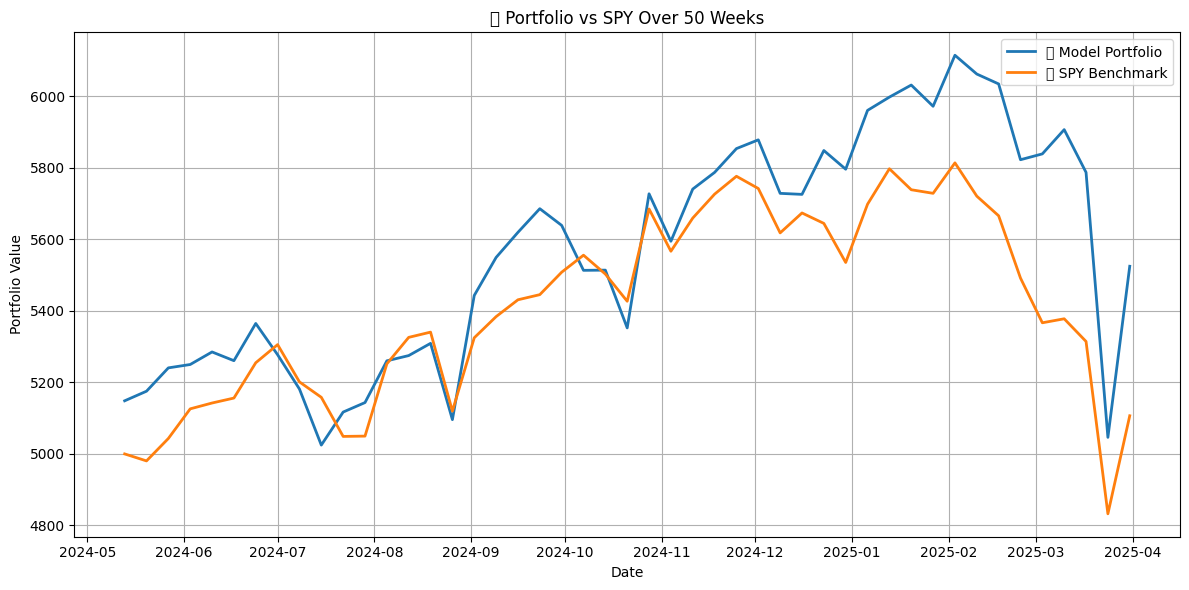

Date  Portfolio Value
0   2024-05-13          5148.47
1   2024-05-20          5175.33
2   2024-05-27          5240.56
3   2024-06-03          5249.99
4   2024-06-10          5285.08
5   2024-06-17          5260.67
6   2024-06-24          5364.72
7   2024-07-01          5277.30
8   2024-07-08          5181.40
9   2024-07-15          5024.68
10  2024-07-22          5117.01
11  2024-07-29          5143.57
12  2024-08-05          5260.26
13  2024-08-12          5274.93
14  2024-08-19          5309.14
15  2024-08-26          5095.81
16  2024-09-02          5443.03
17  2024-09-09          5549.35
18  2024-09-16          5619.53
19  2024-09-23          5685.63
20  2024-09-30          5638.98
21  2024-10-07          5513.28
22  2024-10-14          5513.85
23  2024-10-21          5352.33
24  2024-10-28          5727.25
25  2024-11-04          5594.55
26  2024-11-11          5740.47
27  2024-11-18          5787.10
28  2024-11-25          5853.67
29  2024-12-02          5878.12
30  2024-12-09          5728.52
31  2024-12-16          5725.67
32  2024-12-23          5848.29
33  2024-12-30          5796.03
34  2025-01-06          5960.50
35  2025-01-13          5997.64
36  2025-01-20          6031.35
37  2025-01-27          5972.01
38  2025-02-03          6114.63
39  2025-02-10          6062.12
40  2025-02-17          6034.44
41  2025-02-24          5822.56
42  2025-03-03          5838.87
43  2025-03-10          5906.70
44  2025-03-17          5787.15
45  2025-03-24          5046.28
46  2025-03-31          5524.70

Date  Win Count  Loss Count
0   2024-05-13          2           0
1   2024-05-20          2           0
2   2024-05-27          1           1
3   2024-06-03          1           1
4   2024-06-10          1           1
5   2024-06-17          1           1
6   2024-06-24          2           0
7   2024-07-01          1           1
8   2024-07-08          0           2
9   2024-07-15          0           2
10  2024-07-22          1           1
11  2024-07-29          2           0
12  2024-08-05          2           0
13  2024-08-12          1           1
14  2024-08-19          2           0
15  2024-08-26          0           2
16  2024-09-02          2           0
17  2024-09-09          2           0
18  2024-09-16          2           0
19  2024-09-23          2           0
20  2024-09-30          0           2
21  2024-10-07          0           2
22  2024-10-14          1           1
23  2024-10-21          0           2
24  2024-10-28          2           0
25  2024-11-04          0           2
26  2024-11-11          2           0
27  2024-11-18          2           0
28  2024-11-25          1           1
29  2024-12-02          1           1
30  2024-12-09          0           2
31  2024-12-16          1           1
32  2024-12-23          1           1
33  2024-12-30          1           1
34  2025-01-06          2           0
35  2025-01-13          2           0
36  2025-01-20          1           1
37  2025-01-27          1           1
38  2025-02-03          2           0
39  2025-02-10          1           1
40  2025-02-17          1           1
41  2025-02-24          0           2
42  2025-03-03          1           1
43  2025-03-10          2           0
44  2025-03-17          0           2
45  2025-03-24          0           2
46  2025-03-31          2           0

In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load and clean SPY CSV ===
spy = pd.read_csv("../dataset/SPY.csv", skiprows=2)
spy.columns = ["Date", "SPY"]
spy['Date'] = pd.to_datetime(spy['Date'], errors='coerce')
spy = spy.dropna().sort_values("Date").reset_index(drop=True)
spy.set_index("Date", inplace=True)

# === Ensure datetime ===
backtest_df = averaged_test_df.copy()
backtest_df['Date'] = pd.to_datetime(backtest_df['Date'])
backtest_df = backtest_df.sort_values('Date')
price_df.index = pd.to_datetime(price_df.index, errors='coerce')

# === Backtest last 50 weeks ===
dates = backtest_df['Date'].drop_duplicates().sort_values().unique()[-50:]

portfolio = 5000
history = []
win_loss_log = []
spy_returns = []

print("🔁 Starting Backtest with $5000\n")

for week in dates:
    week_df = backtest_df[backtest_df['Date'] == week].copy()
    week_df['Score'] = week_df['Predicted']
    top2 = week_df.sort_values('Score', ascending=False).head(2)

    cash_per_etf = portfolio / 2
    unused_cash = 0
    new_value = 0
    wins = 0
    losses = 0

    print(f"\n📅 Week: {week.date()} | Starting Portfolio: ${portfolio:.2f}")

    for _, row in top2.iterrows():
        etf = row['ETF']
        pred_return = row['Predicted']

        try:
            available_dates = price_df.index[price_df[etf].notna()]
            buy_date = available_dates[available_dates <= week].max()
            sell_date = available_dates[available_dates > week].min()

            if pd.isna(buy_date) or pd.isna(sell_date):
                raise ValueError("Missing price")

            buy_price = price_df.loc[buy_date, etf]
            sell_price = price_df.loc[sell_date, etf]
        except:
            print(f"⚠️ Missing price for {etf} on {week.date()}")
            continue

        shares = cash_per_etf / buy_price
        invested = shares * buy_price
        final_val = shares * sell_price
        gain = final_val - invested
        actual_return = gain / invested
        predicted_pct = pred_return * 100

        if gain >= 0:
            wins += 1
        else:
            losses += 1

        print(f"📈 {etf} | Predicted: {predicted_pct:.2f}% | Buy {shares:.2f} @ {buy_price:.2f} → Sell @ {sell_price:.2f} = ${final_val:.2f} (Actual Return: {actual_return:.2%})")

        new_value += final_val
        unused_cash += cash_per_etf - invested

    portfolio = new_value + unused_cash
    history.append({'Date': week.date(), 'Portfolio Value': round(portfolio, 2)})
    win_loss_log.append({'Date': week.date(), 'Win Count': wins, 'Loss Count': losses})

    # === SPY benchmark tracking
    try:
        spy_price_start = spy.asof(week)['SPY']
        spy_price_end = spy[spy.index > week].iloc[0]['SPY']
        spy_return = spy_price_end / spy_price_start
        spy_returns.append(spy_return)
    except:
        spy_returns.append(np.nan)

# === Create DataFrames ===
backtest_result_df = pd.DataFrame(history)
win_loss_df = pd.DataFrame(win_loss_log)

# === Normalize SPY and Model ===
spy_returns = pd.Series(spy_returns).dropna().values
spy_perf = spy_returns.cumprod() / spy_returns[0] * 5000
model_perf = backtest_result_df['Portfolio Value'].values

# === Plot comparison ===
plt.figure(figsize=(12, 6))
plt.plot(backtest_result_df['Date'], model_perf, label='📈 Model Portfolio', linewidth=2)
plt.plot(backtest_result_df['Date'][:len(spy_perf)], spy_perf, label='📊 SPY Benchmark', linewidth=2)
plt.title("🔍 Portfolio vs SPY Over 50 Weeks")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Display Tables ===
from IPython.display import display
display(backtest_result_df)
display(win_loss_df)


C:\Users\user\AppData\Local\Temp\ipykernel_46752\2013871243.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', len(feature_names))
C:\Users\user\AppData\Local\Temp\ipykernel_46752\2013871243.py:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


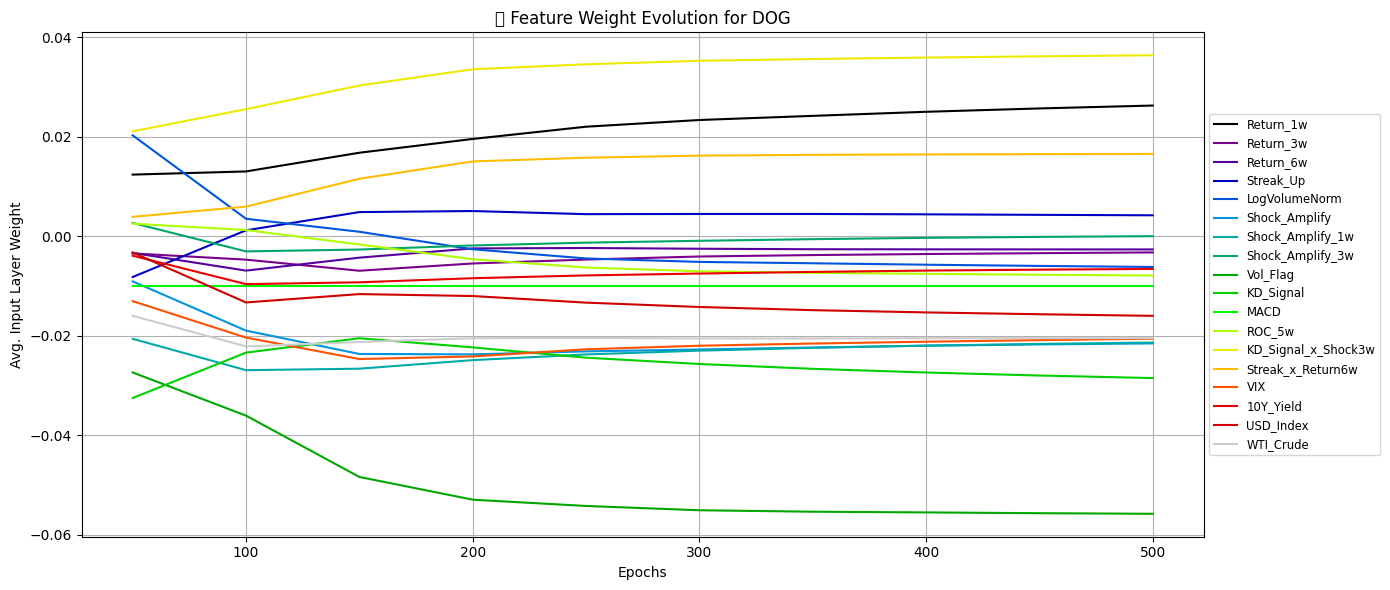

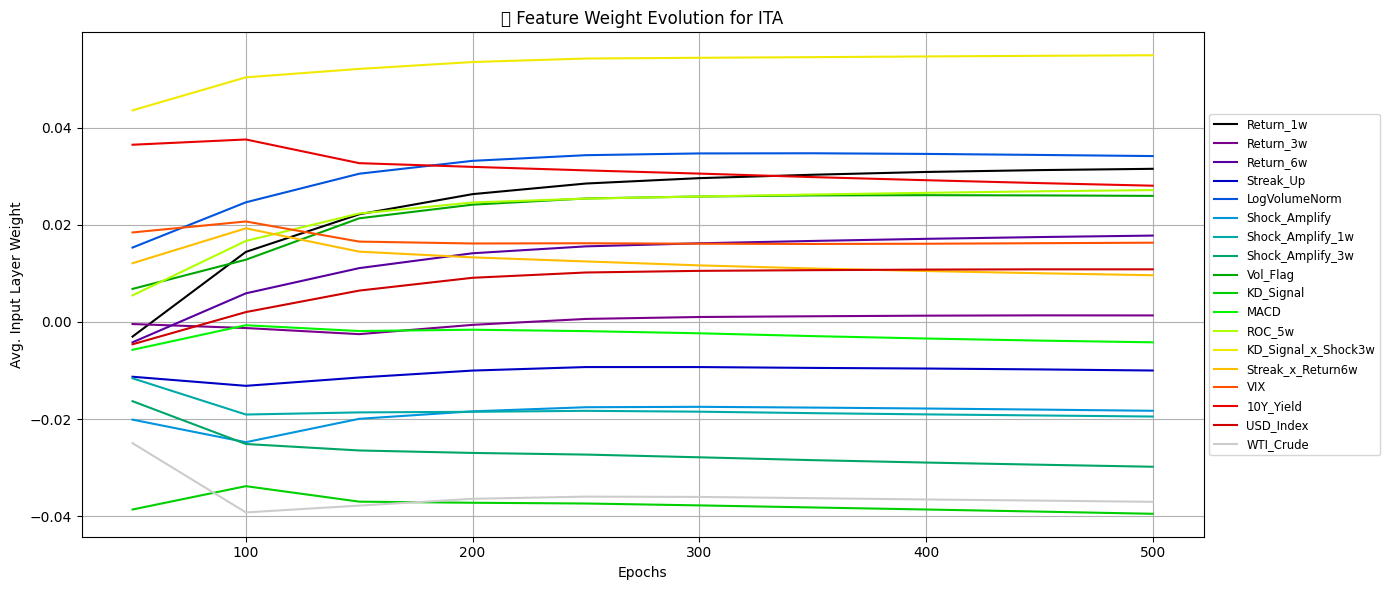

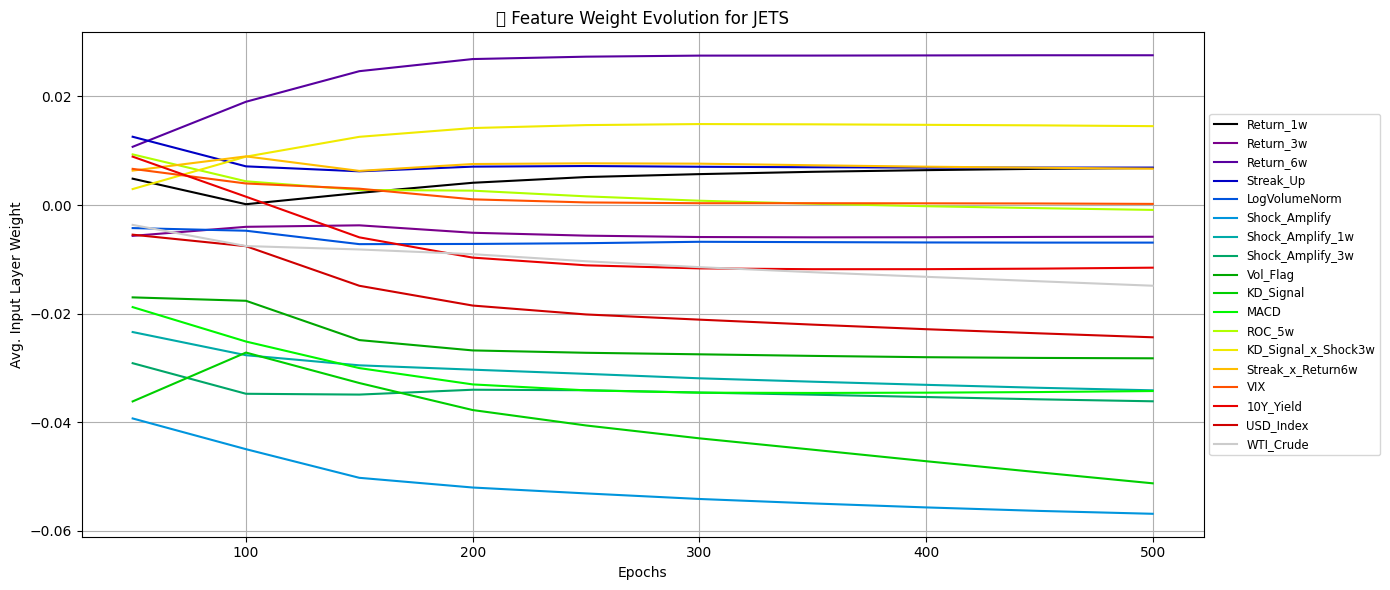

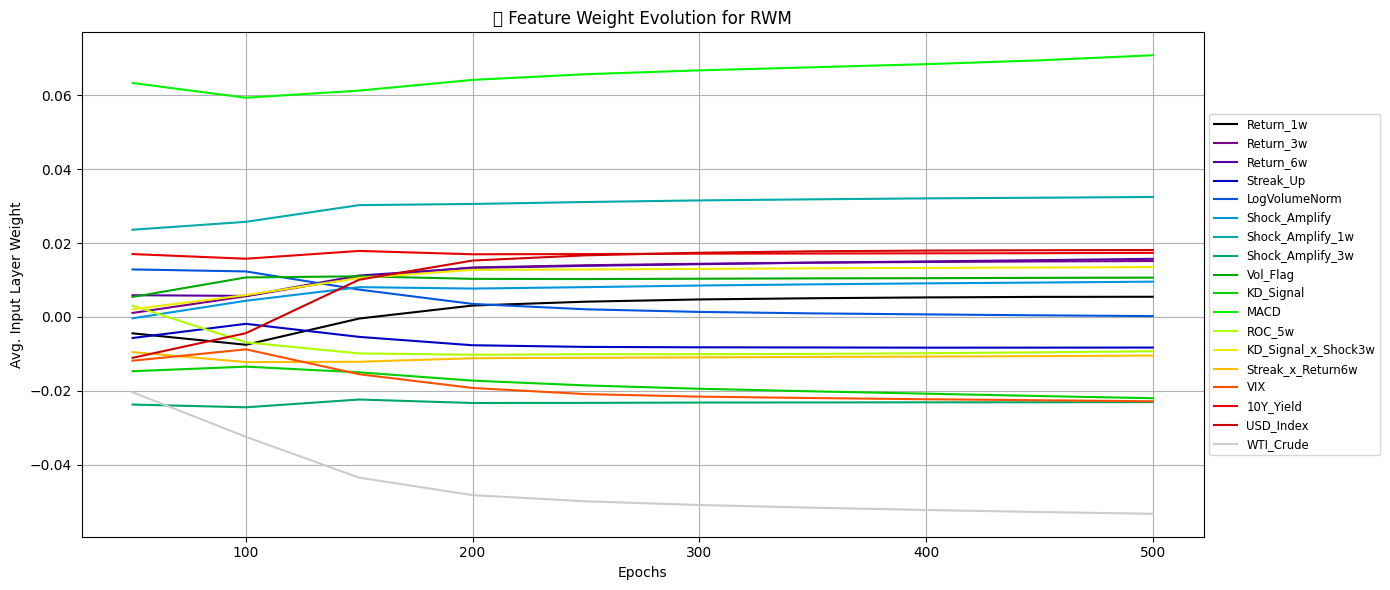

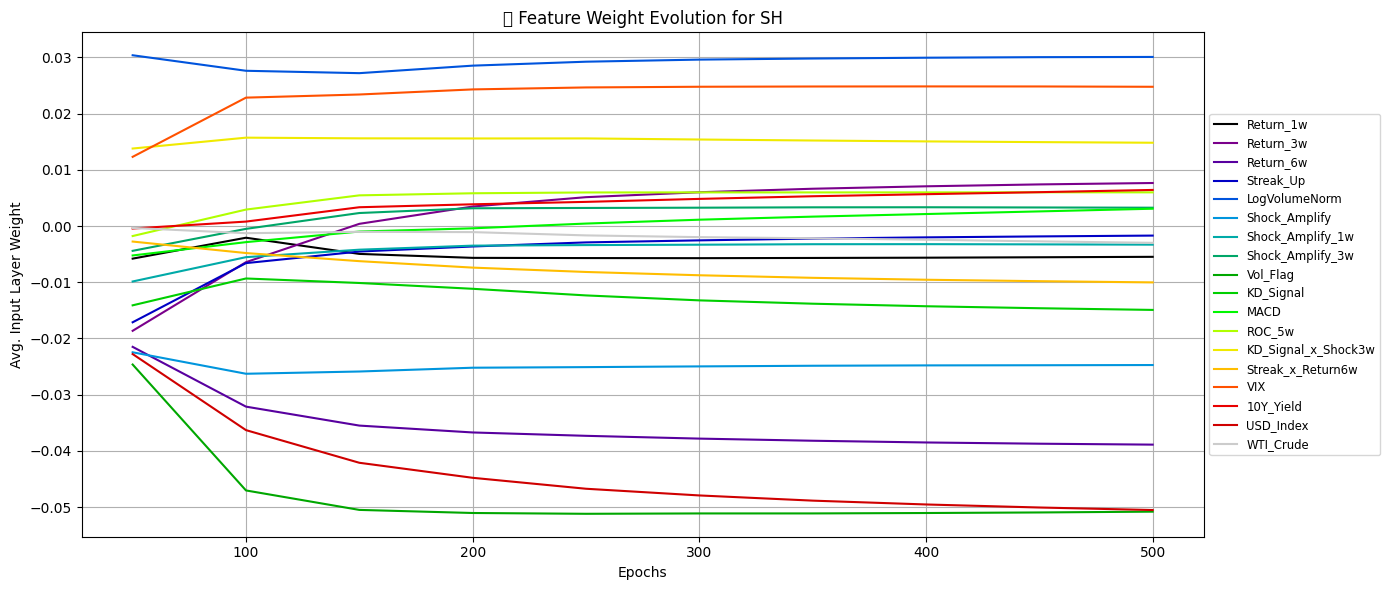

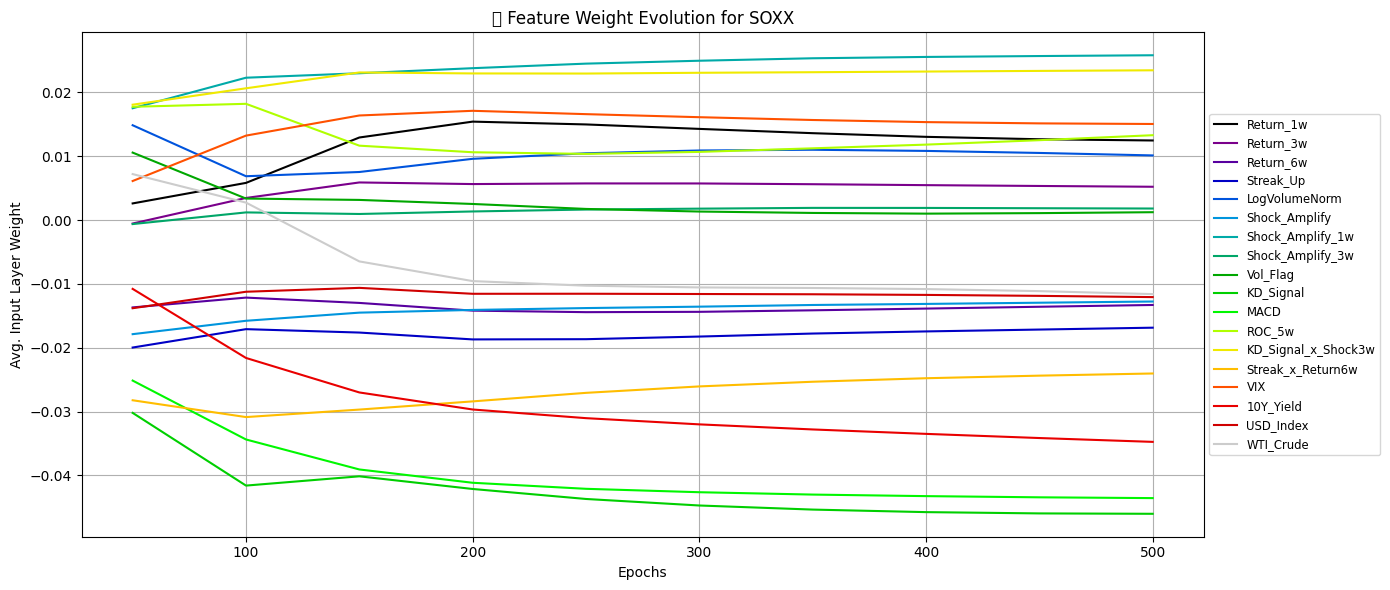

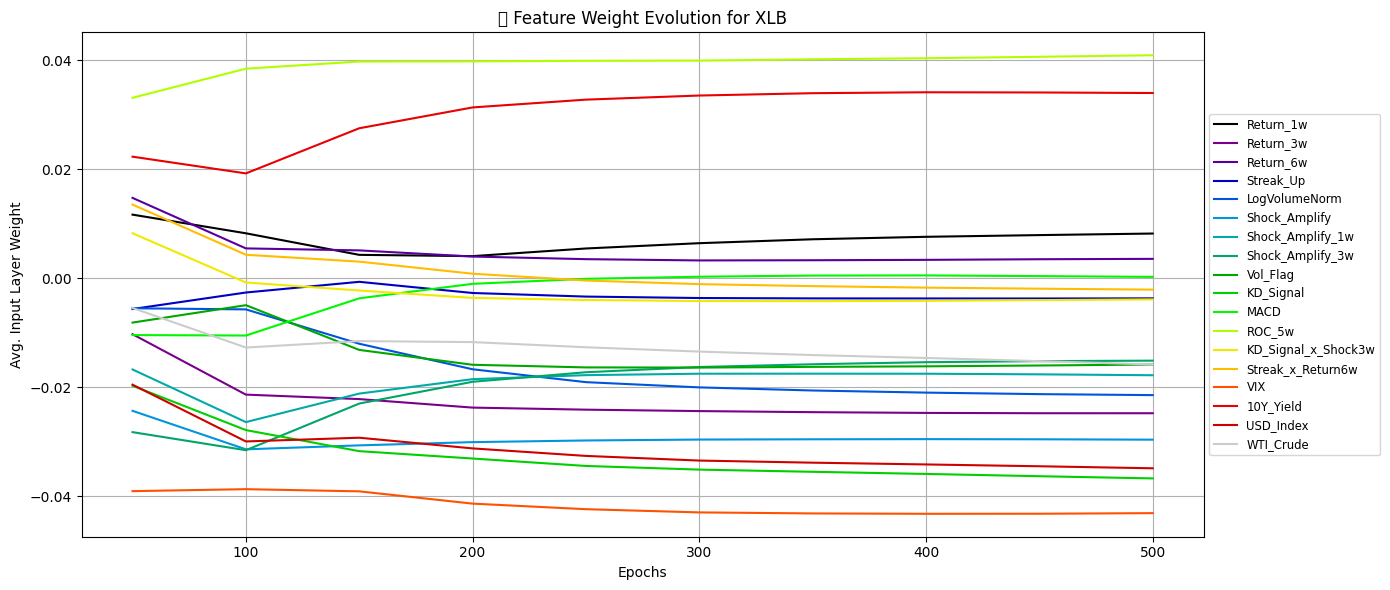

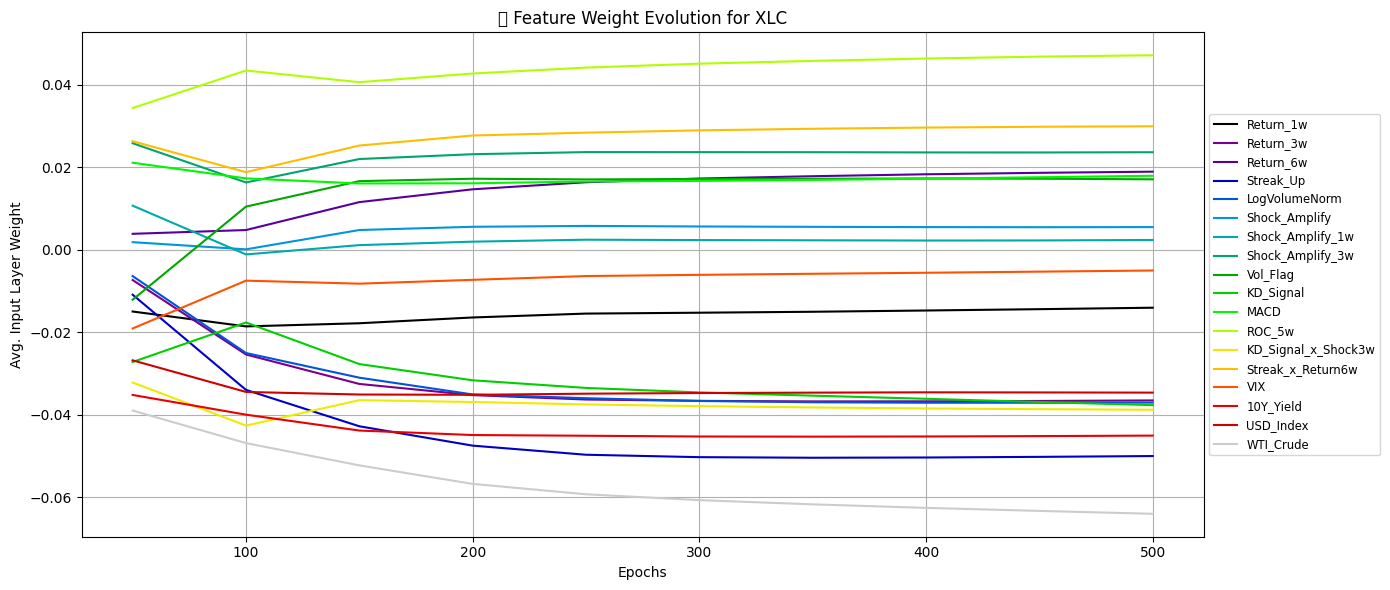

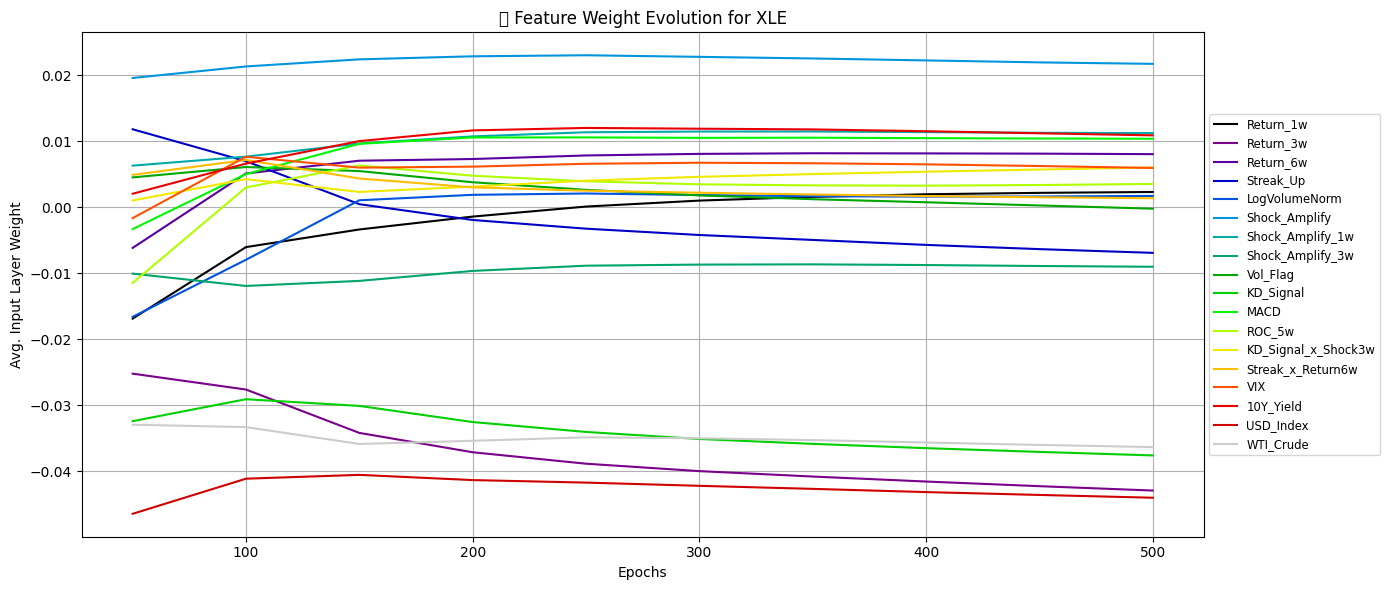

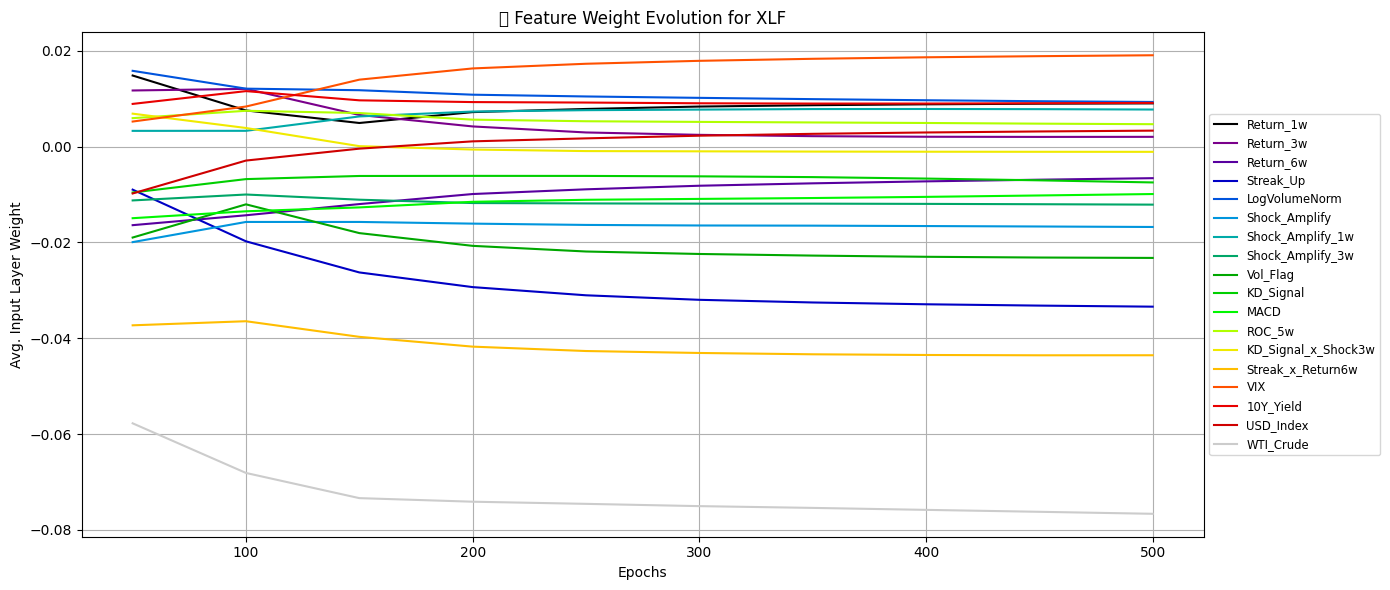

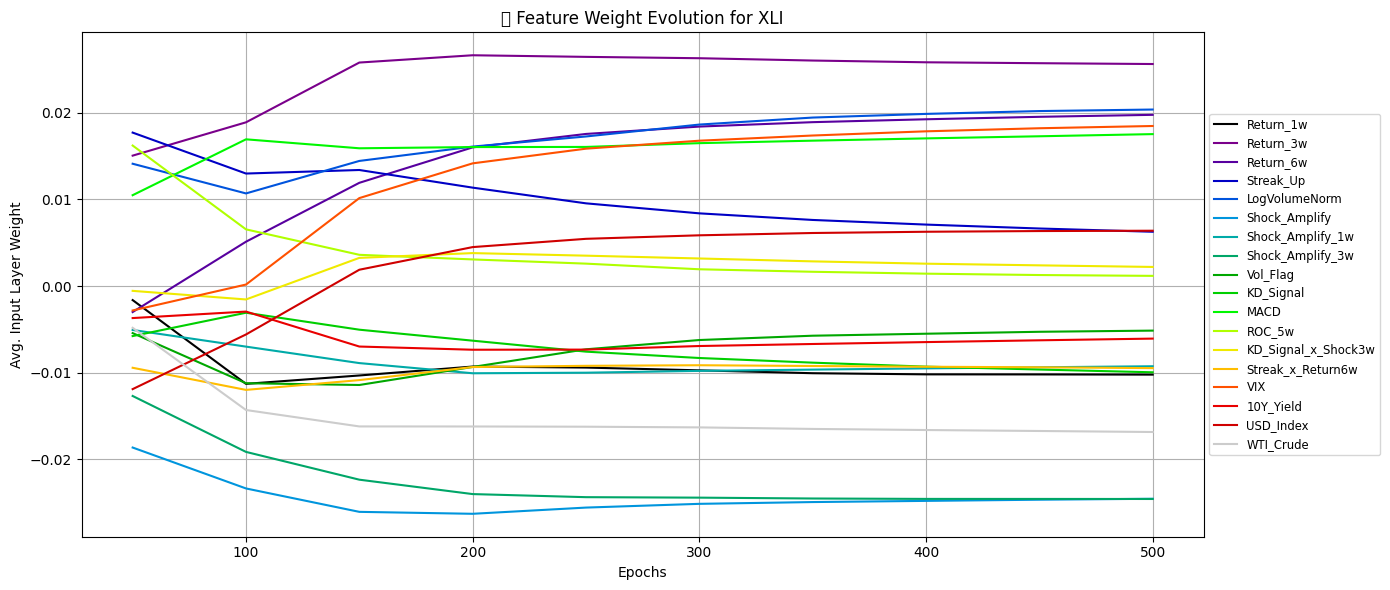

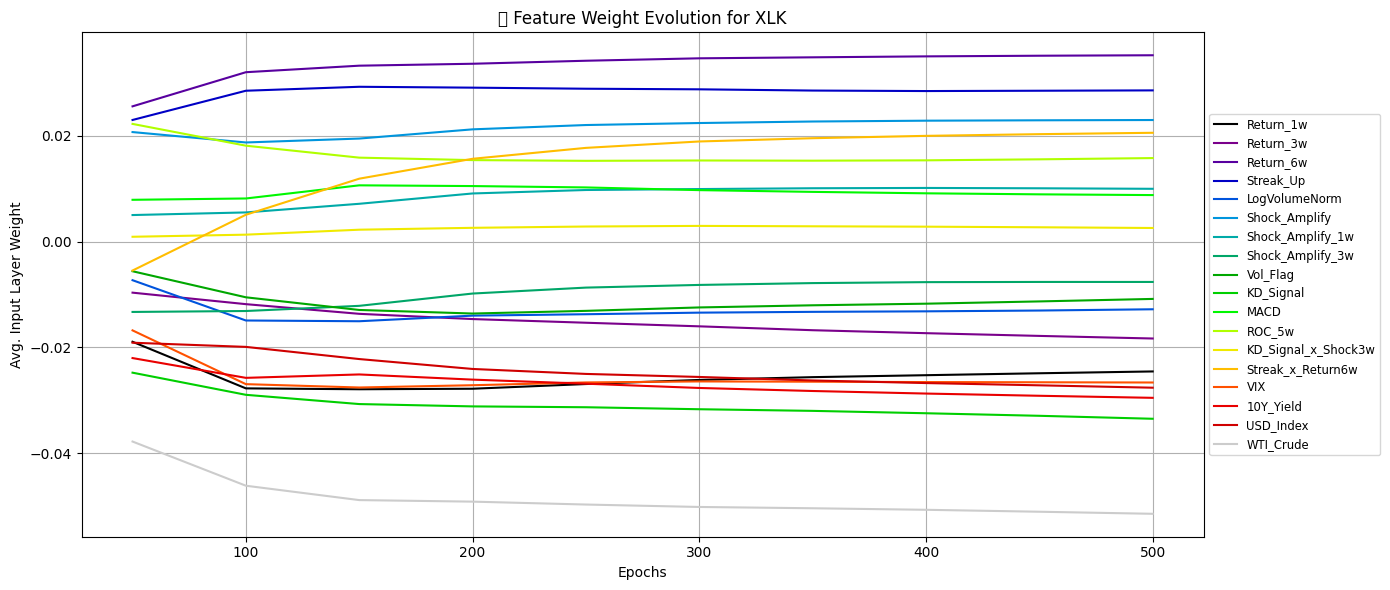

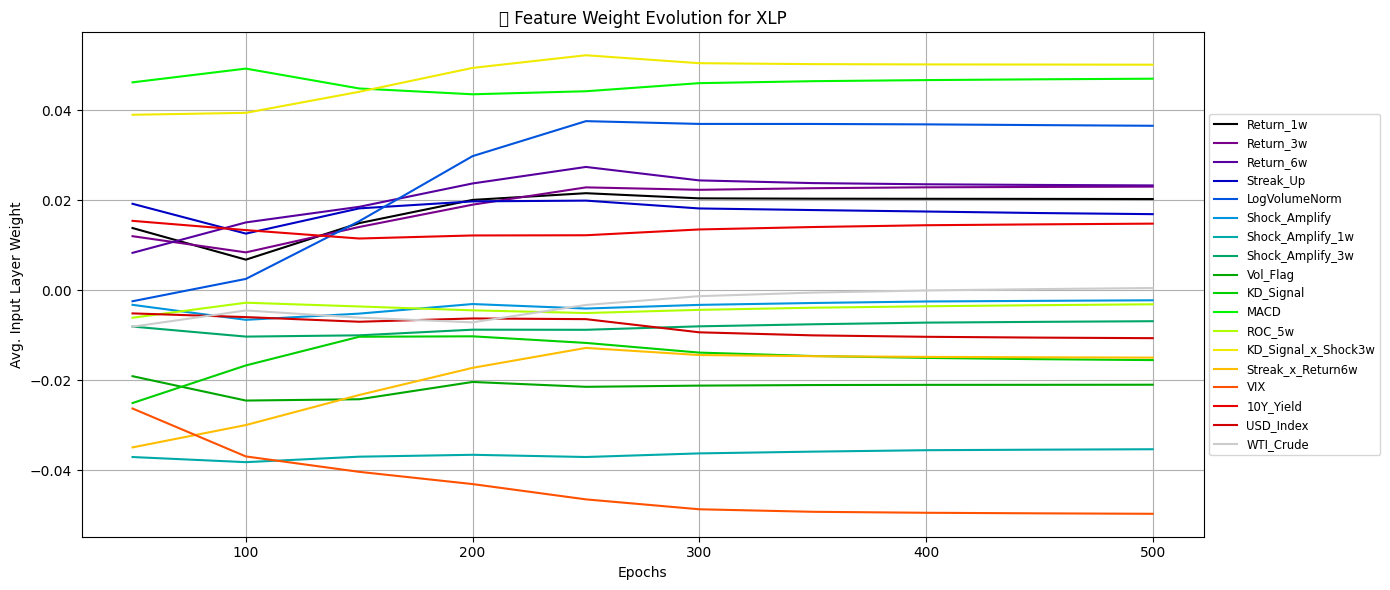

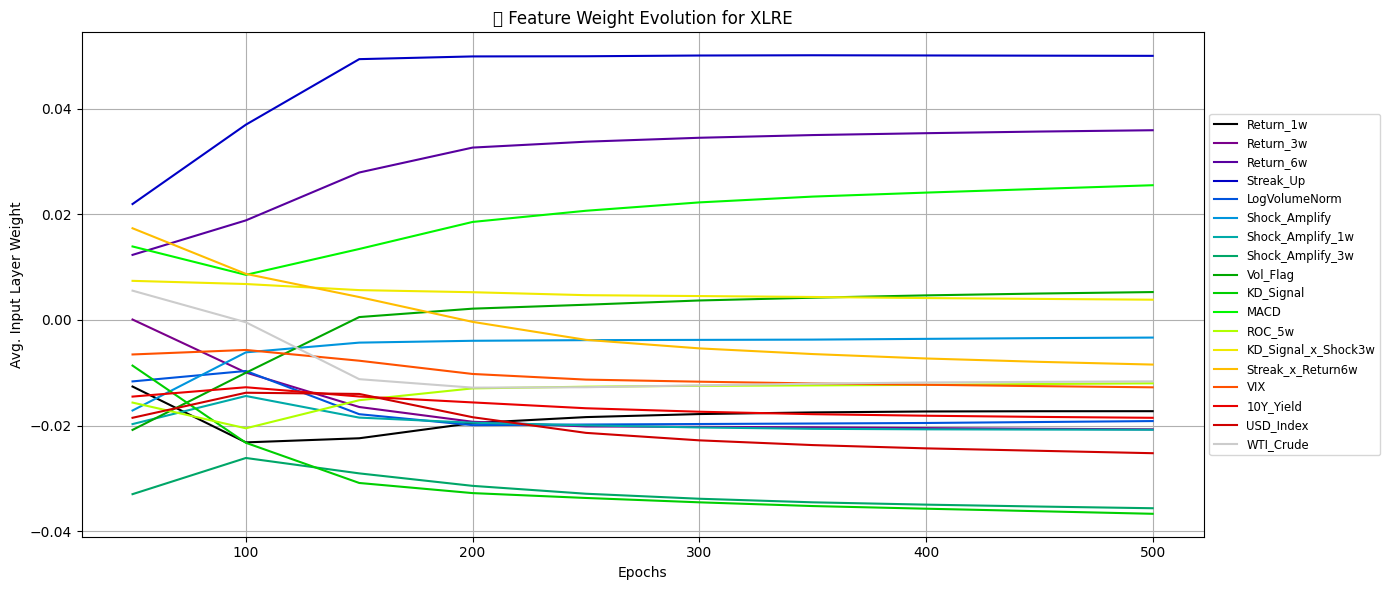

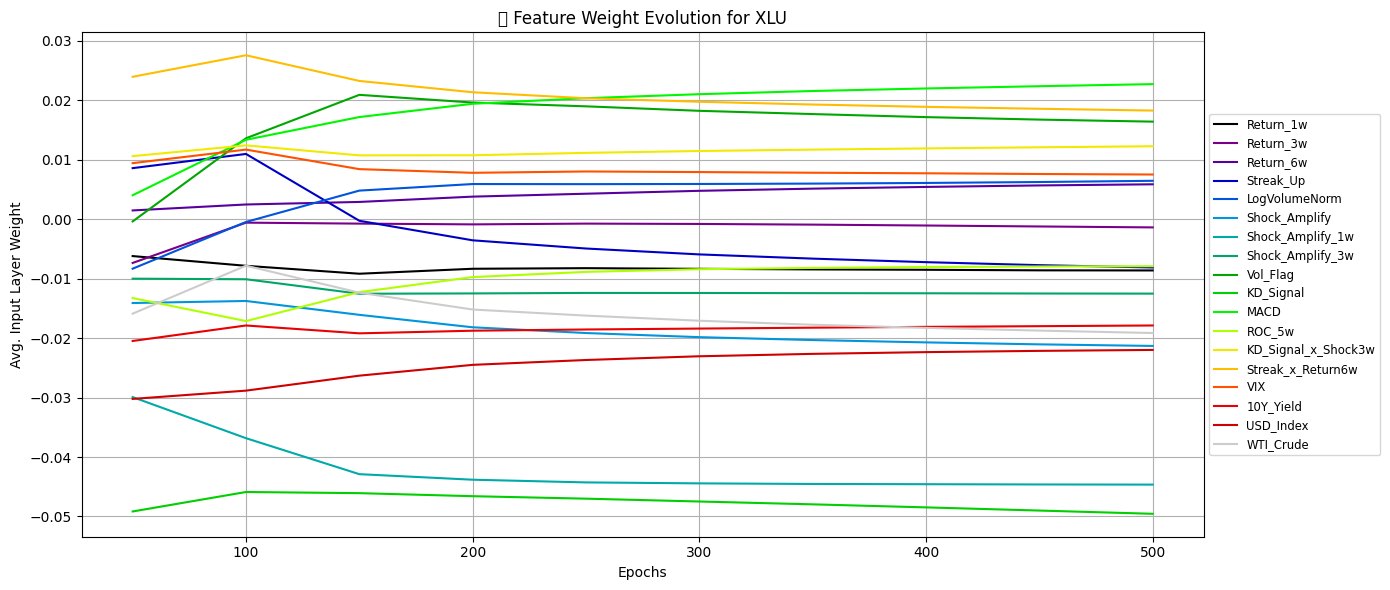

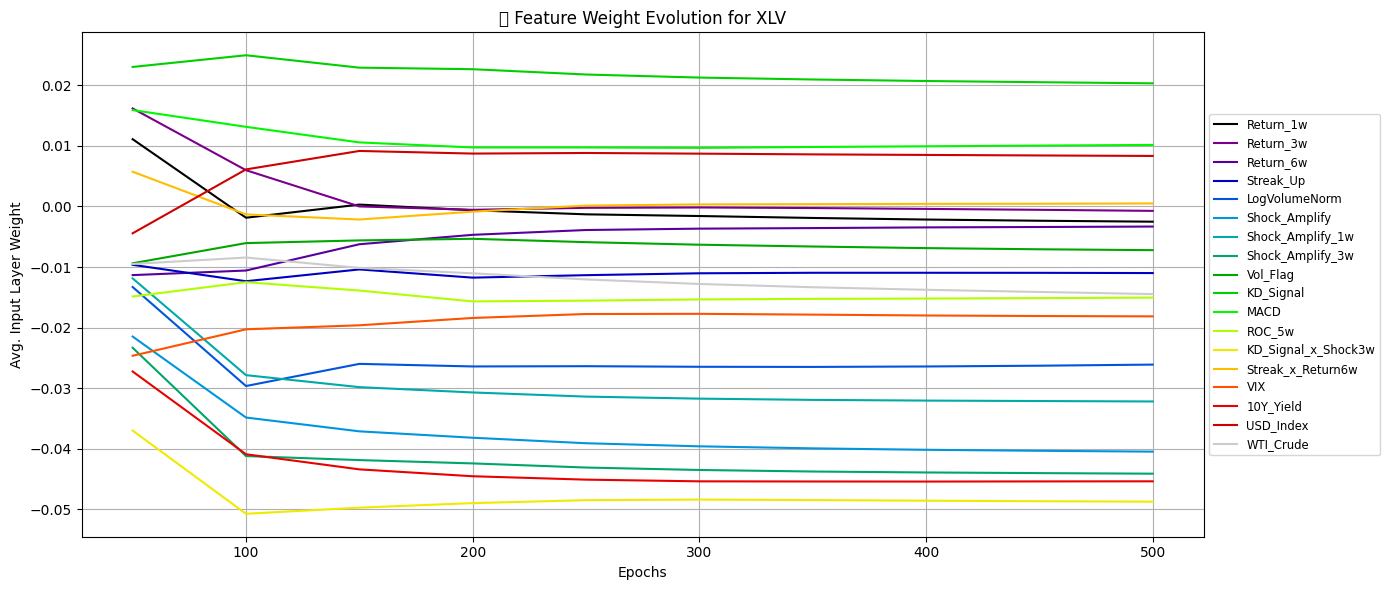

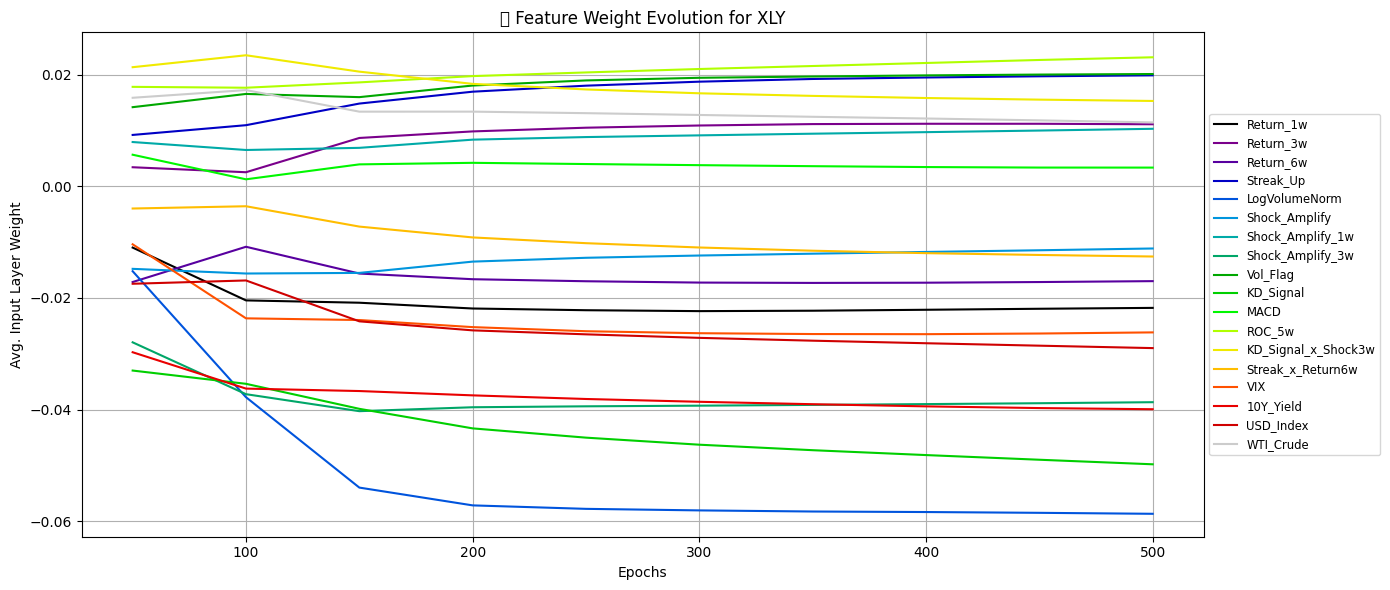

In [393]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# === Updated to match your training features ===
feature_names = [
    'Return_1w', 'Return_3w', 'Return_6w', 'Streak_Up',
    'LogVolumeNorm', 'Shock_Amplify', 'Shock_Amplify_1w', 'Shock_Amplify_3w',
    'Vol_Flag', 'KD_Signal', 'MACD', 'ROC_5w',
    'KD_Signal_x_Shock3w', 'Streak_x_Return6w',
    'VIX', '10Y_Yield', 'USD_Index', 'WTI_Crude'
]

# === Color mapping for features ===
cmap = cm.get_cmap('nipy_spectral', len(feature_names))

# === Plot evolution per ETF ===
for etf, snapshots in weight_snapshots.items():
    if not snapshots:
        continue

    try:
        # Try to extract input weights
        fc1_weights = [s['shared.0.weight'].cpu().numpy() for s in snapshots if 'shared.0.weight' in s]
        weight_matrix = np.stack(fc1_weights)  # shape: (n_snapshots, n_nodes, n_features)
        avg_weights = weight_matrix.mean(axis=1)  # shape: (n_snapshots, n_features)
    except Exception as e:
        print(f"⚠️ Skipped {etf} due to error: {e}")
        continue

    plt.figure(figsize=(14, 6))
    for i, fname in enumerate(feature_names):
        try:
            plt.plot(
                range(50, 50 * (len(fc1_weights) + 1), 50),
                avg_weights[:, i],
                label=fname,
                color=cmap(i)
            )
        except IndexError:
            print(f"⚠️ Skipped feature '{fname}' for {etf} due to shape mismatch.")
            continue

    plt.title(f"📈 Feature Weight Evolution for {etf}")
    plt.xlabel("Epochs")
    plt.ylabel("Avg. Input Layer Weight")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_46752\2264829814.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


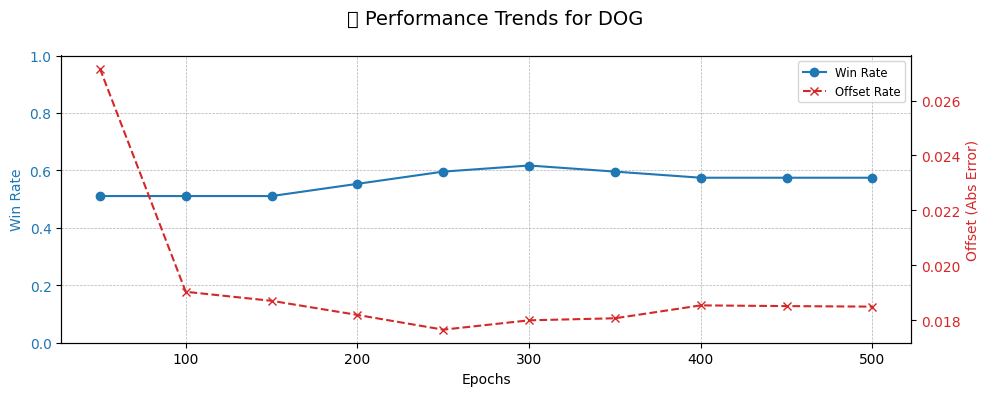

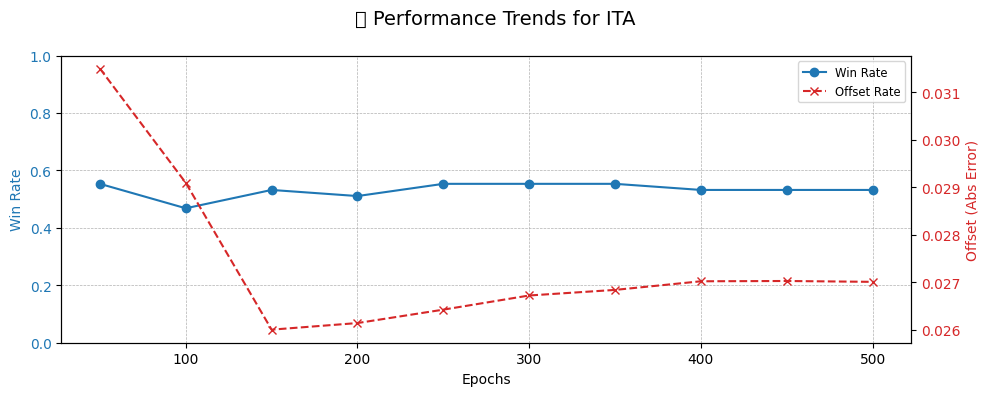

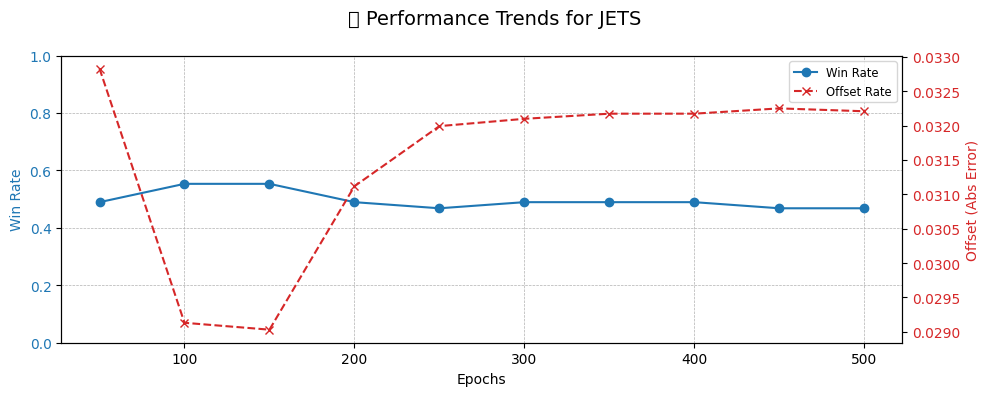

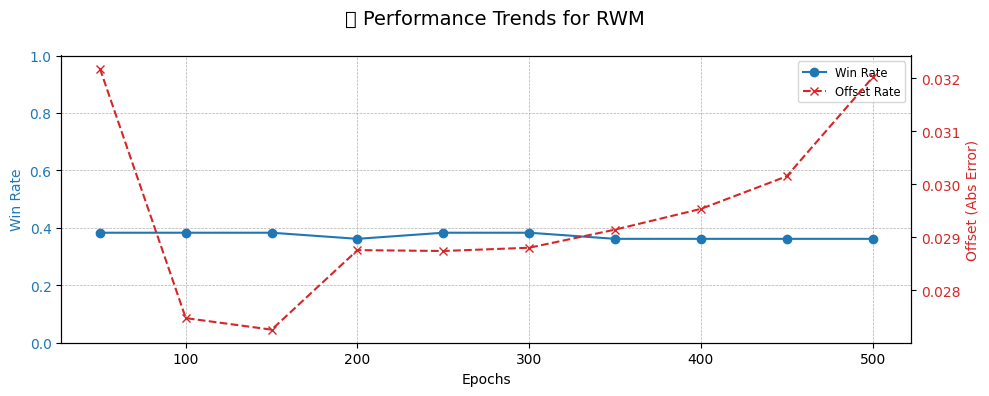

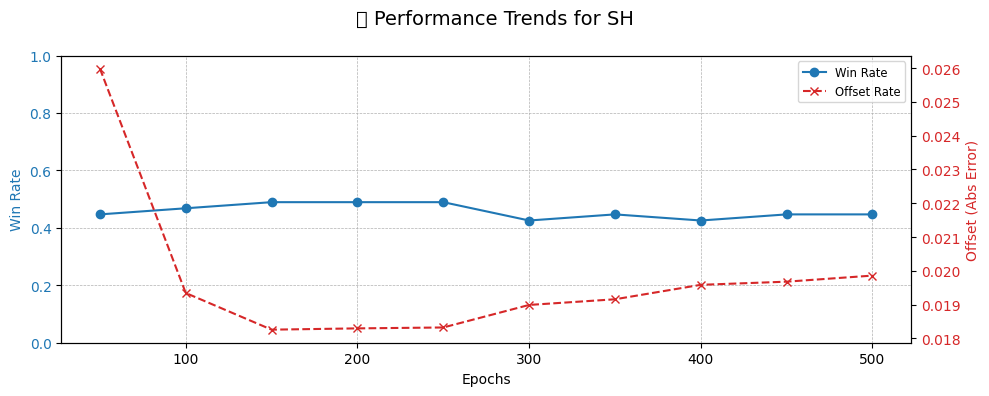

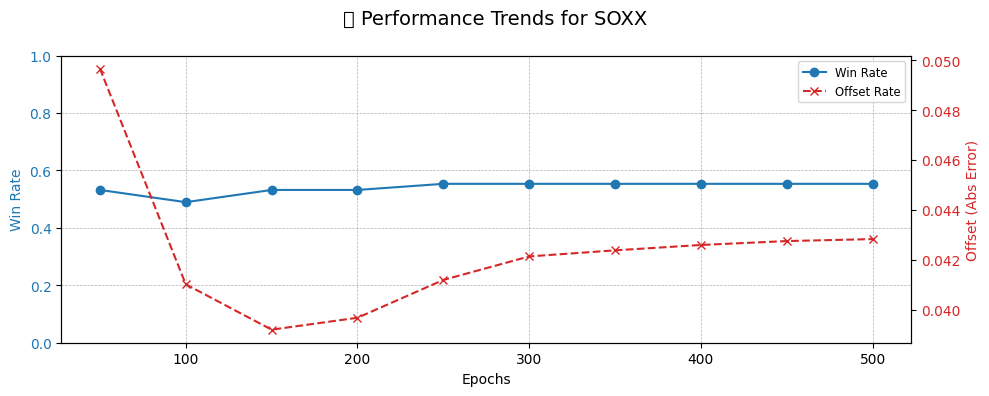

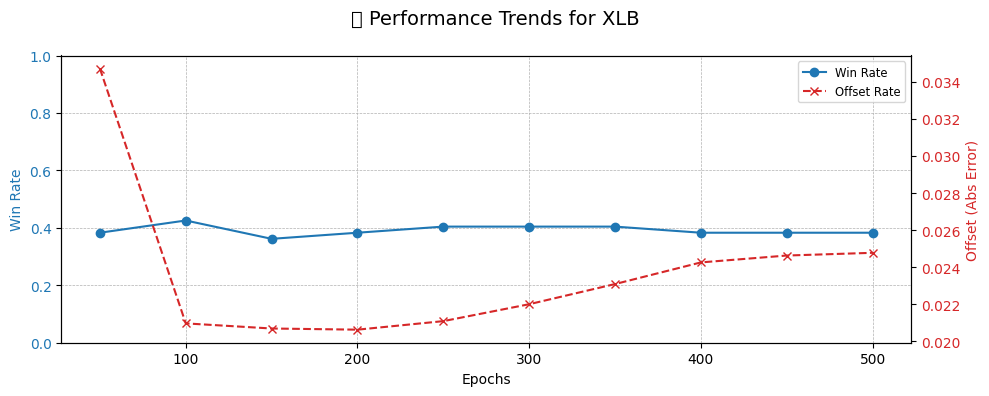

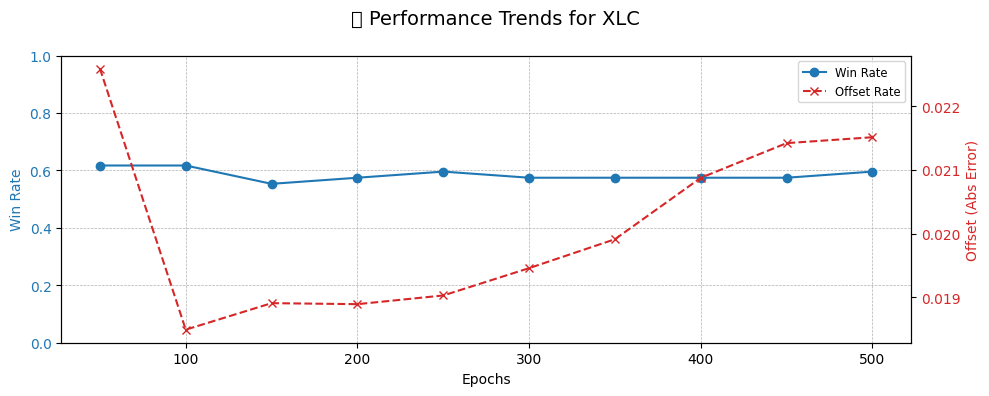

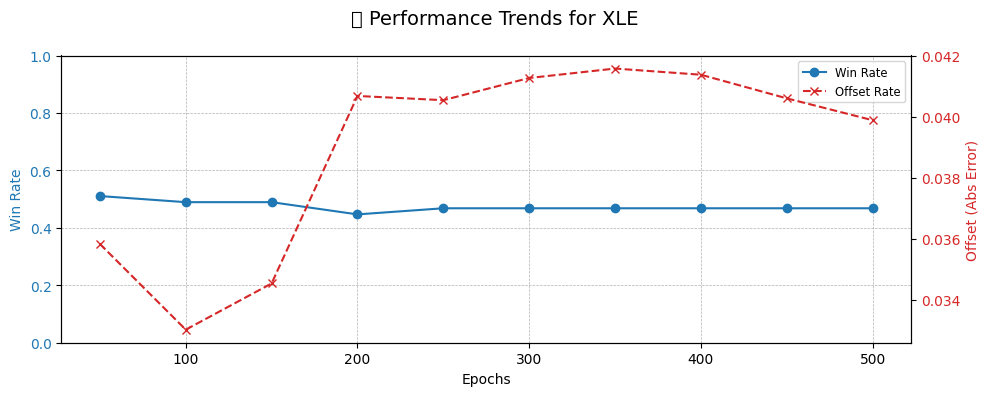

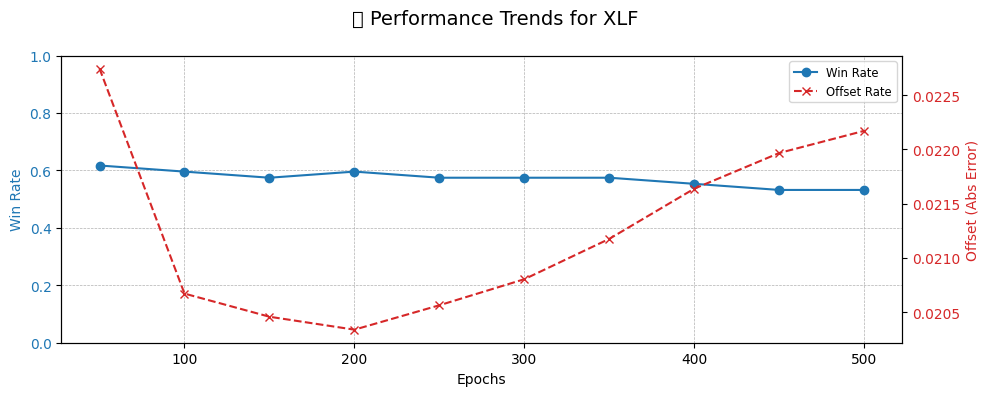

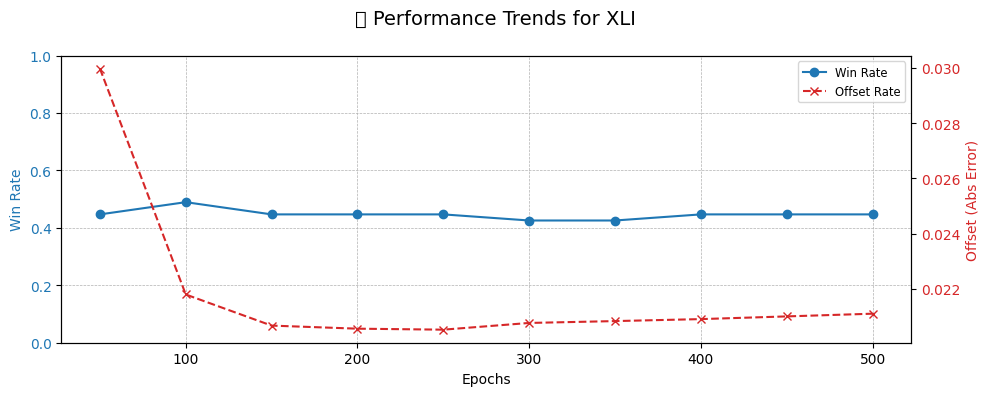

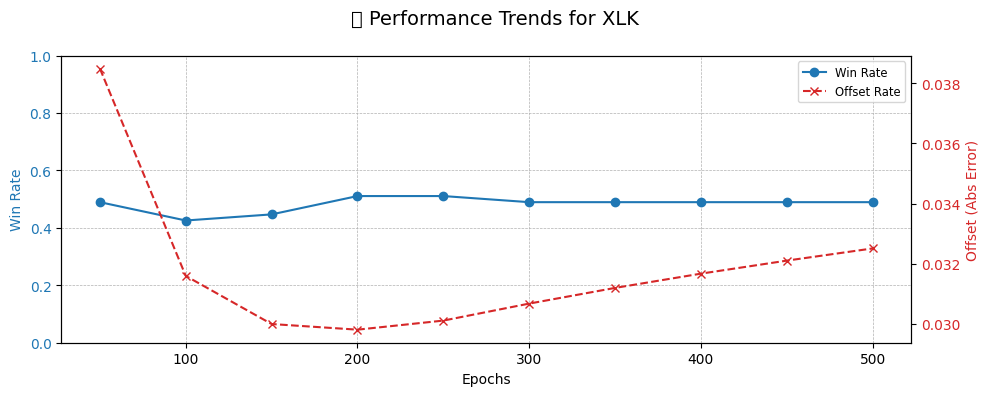

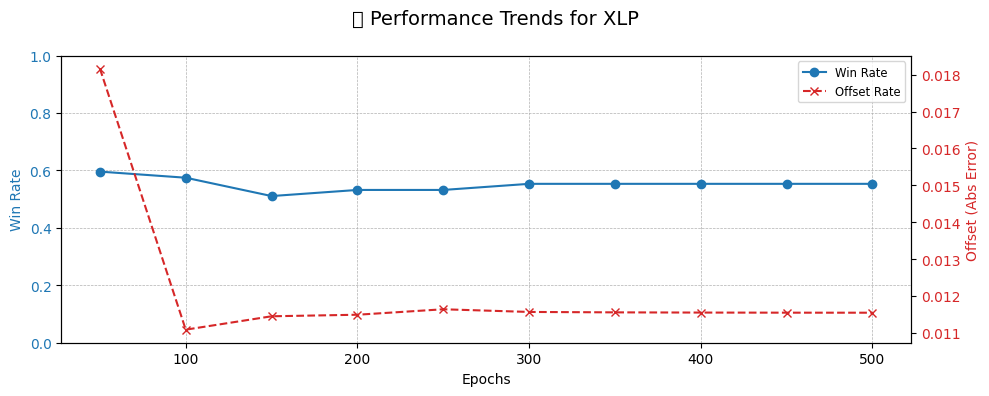

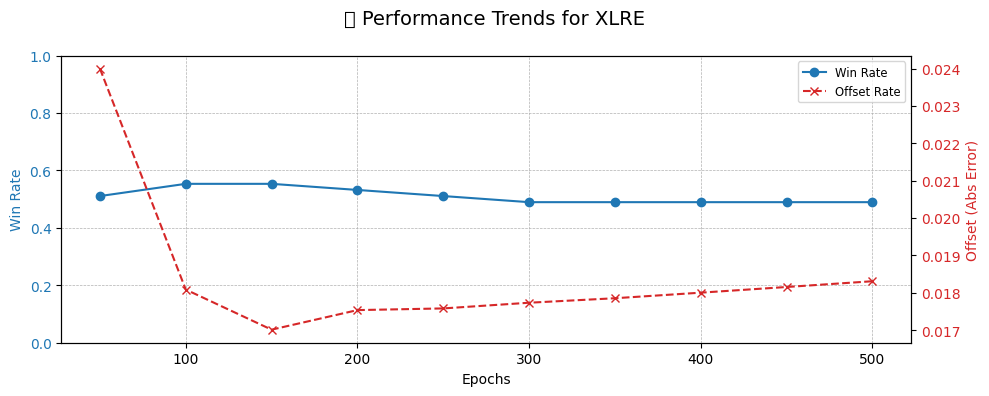

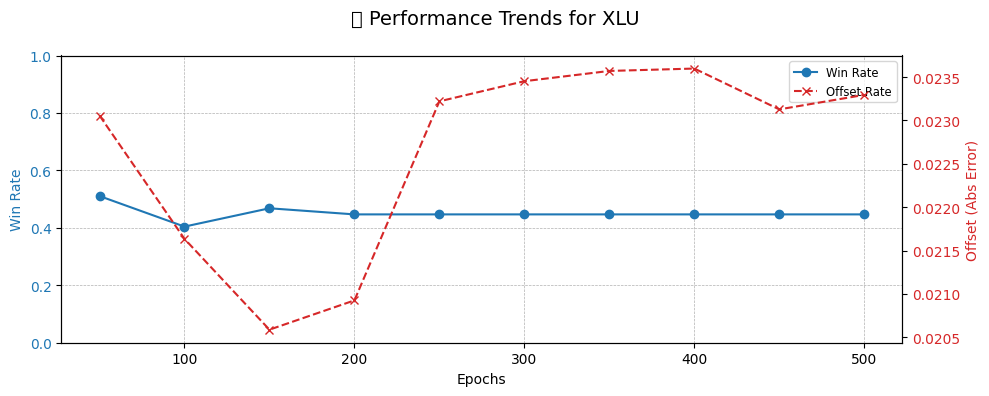

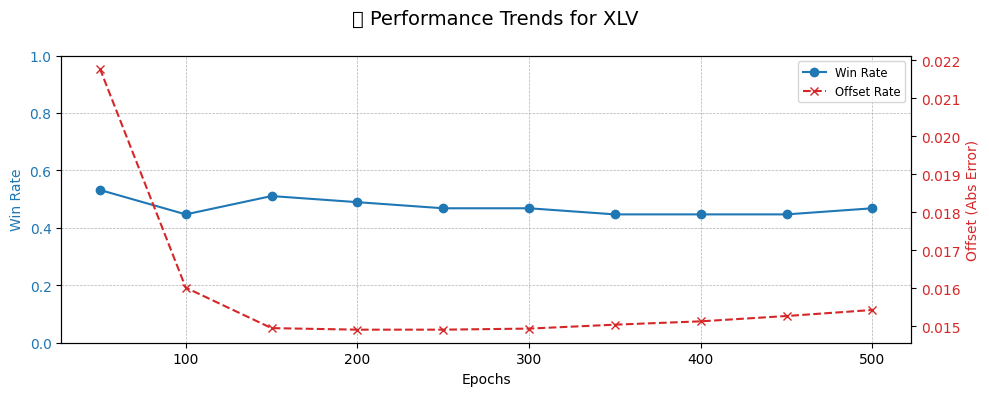

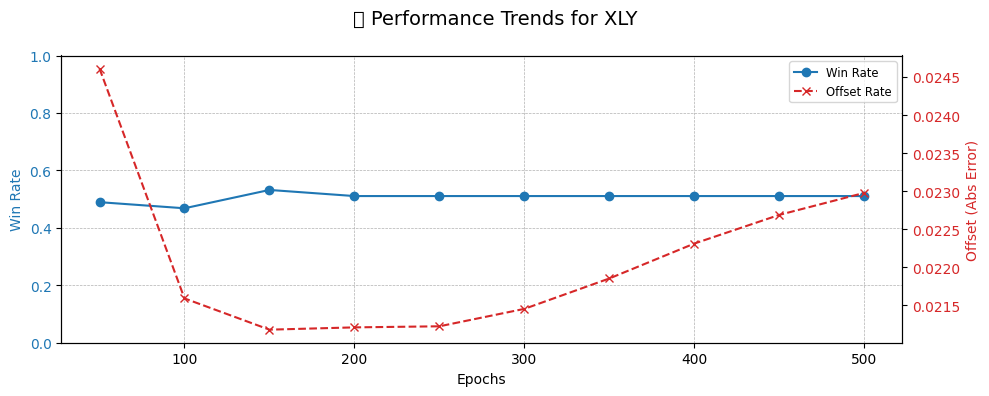

In [394]:
import matplotlib.pyplot as plt

# === Plot Win Rate and Offset for Each ETF ===
for etf in win_rate_history.keys():
    win_data = win_rate_history[etf]
    offset_data = offset_history[etf]

    if not win_data or not offset_data:
        continue

    # Unpack epoch-wise values
    epochs_win, win_values = zip(*win_data)
    epochs_offset, offset_values = zip(*offset_data)

    fig, ax1 = plt.subplots(figsize=(10, 4))
    fig.suptitle(f"📊 Performance Trends for {etf}", fontsize=14)

    # Left Y-axis: Win Rate
    ax1.plot(epochs_win, win_values, color='tab:blue', marker='o', label="Win Rate")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Win Rate", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, 1)
    ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

    # Right Y-axis: Offset Rate
    ax2 = ax1.twinx()
    ax2.plot(epochs_offset, offset_values, color='tab:red', linestyle='--', marker='x', label="Offset Rate")
    ax2.set_ylabel("Offset (Abs Error)", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Combined legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_46752\505412260.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


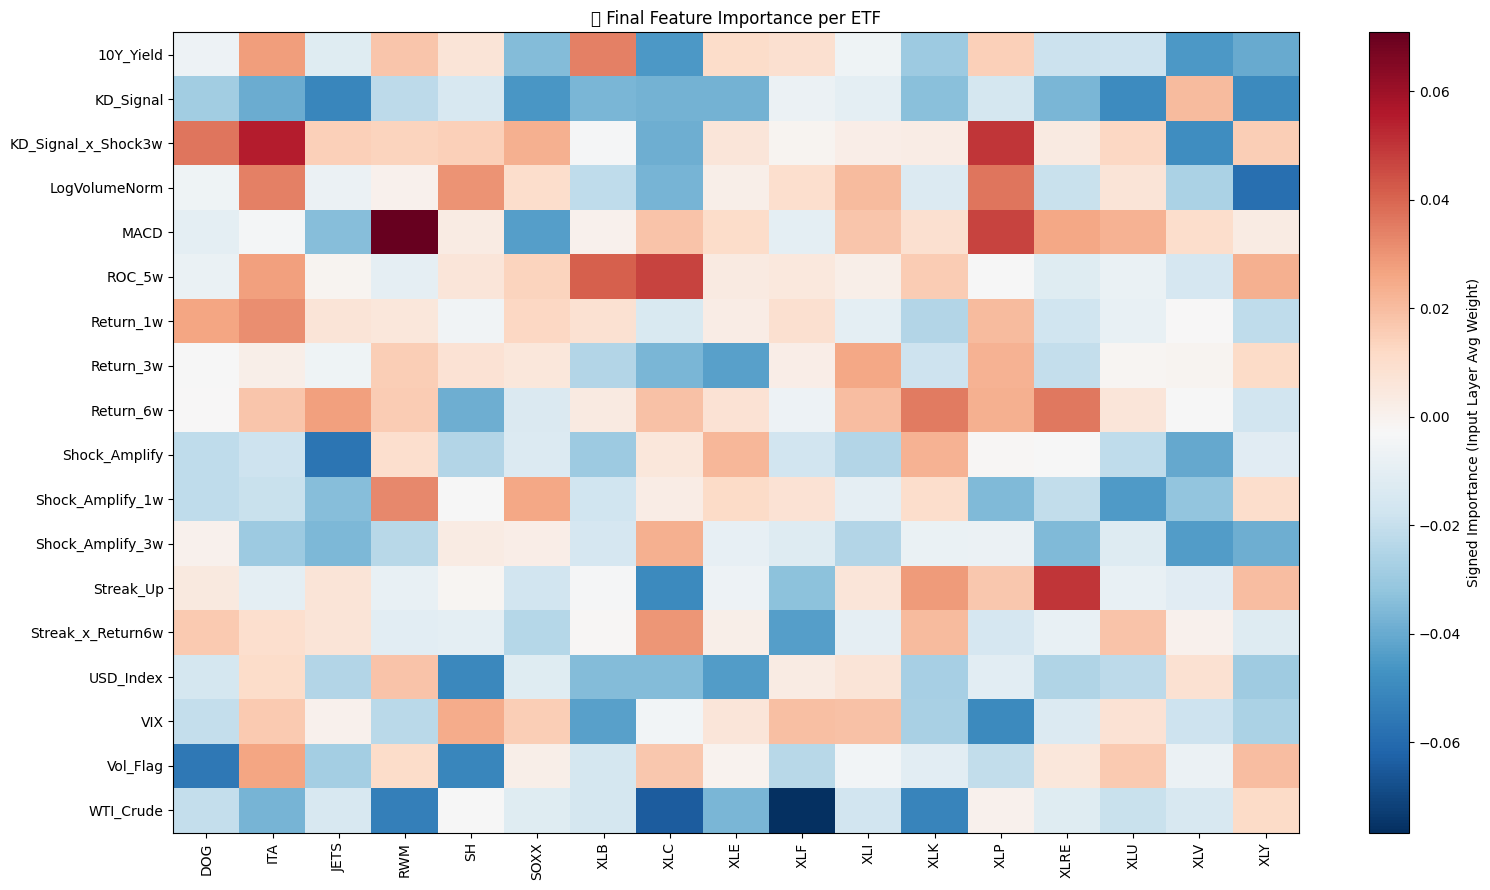

In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Match enhanced model features ===
feature_names = [
    'Return_1w', 'Return_3w', 'Return_6w', 'Streak_Up',
    'LogVolumeNorm', 'Shock_Amplify', 'Shock_Amplify_1w', 'Shock_Amplify_3w',
    'Vol_Flag', 'KD_Signal',
    'MACD', 'ROC_5w', 'KD_Signal_x_Shock3w', 'Streak_x_Return6w',
    'VIX', '10Y_Yield', 'USD_Index', 'WTI_Crude'
]

importance_records = []

# === Collect average input weights for each ETF from final snapshot ===
for etf, snapshots in weight_snapshots.items():
    if not snapshots:
        continue

    final_state = snapshots[-1]  # last saved state dict
    key = 'shared.0.weight'

    if key not in final_state:
        print(f"⚠️ {key} not found in snapshot for {etf}")
        continue

    fc1_weight = final_state[key].cpu().numpy()  # shape: (n_hidden, n_features)
    avg_weight = fc1_weight.mean(axis=0)  # → (n_features,)

    for i, fname in enumerate(feature_names):
        importance_records.append({
            'ETF': etf,
            'Feature': fname,
            'Weight': avg_weight[i],
            'AbsImportance': abs(avg_weight[i])
        })

# === Assemble into DataFrame ===
importance_df = pd.DataFrame(importance_records)

# === Pivot for heatmap ===
heatmap_df = importance_df.pivot(index='Feature', columns='ETF', values='Weight')

# === Plot heatmap ===
plt.figure(figsize=(16, 9))
im = plt.imshow(heatmap_df.values, aspect='auto', cmap='RdBu_r', interpolation='nearest')

plt.colorbar(im, label='Signed Importance (Input Layer Avg Weight)')
plt.xticks(np.arange(len(heatmap_df.columns)), heatmap_df.columns, rotation=90)
plt.yticks(np.arange(len(heatmap_df.index)), heatmap_df.index)
plt.title("📊 Final Feature Importance per ETF")
plt.tight_layout()
plt.grid(False)
plt.show()


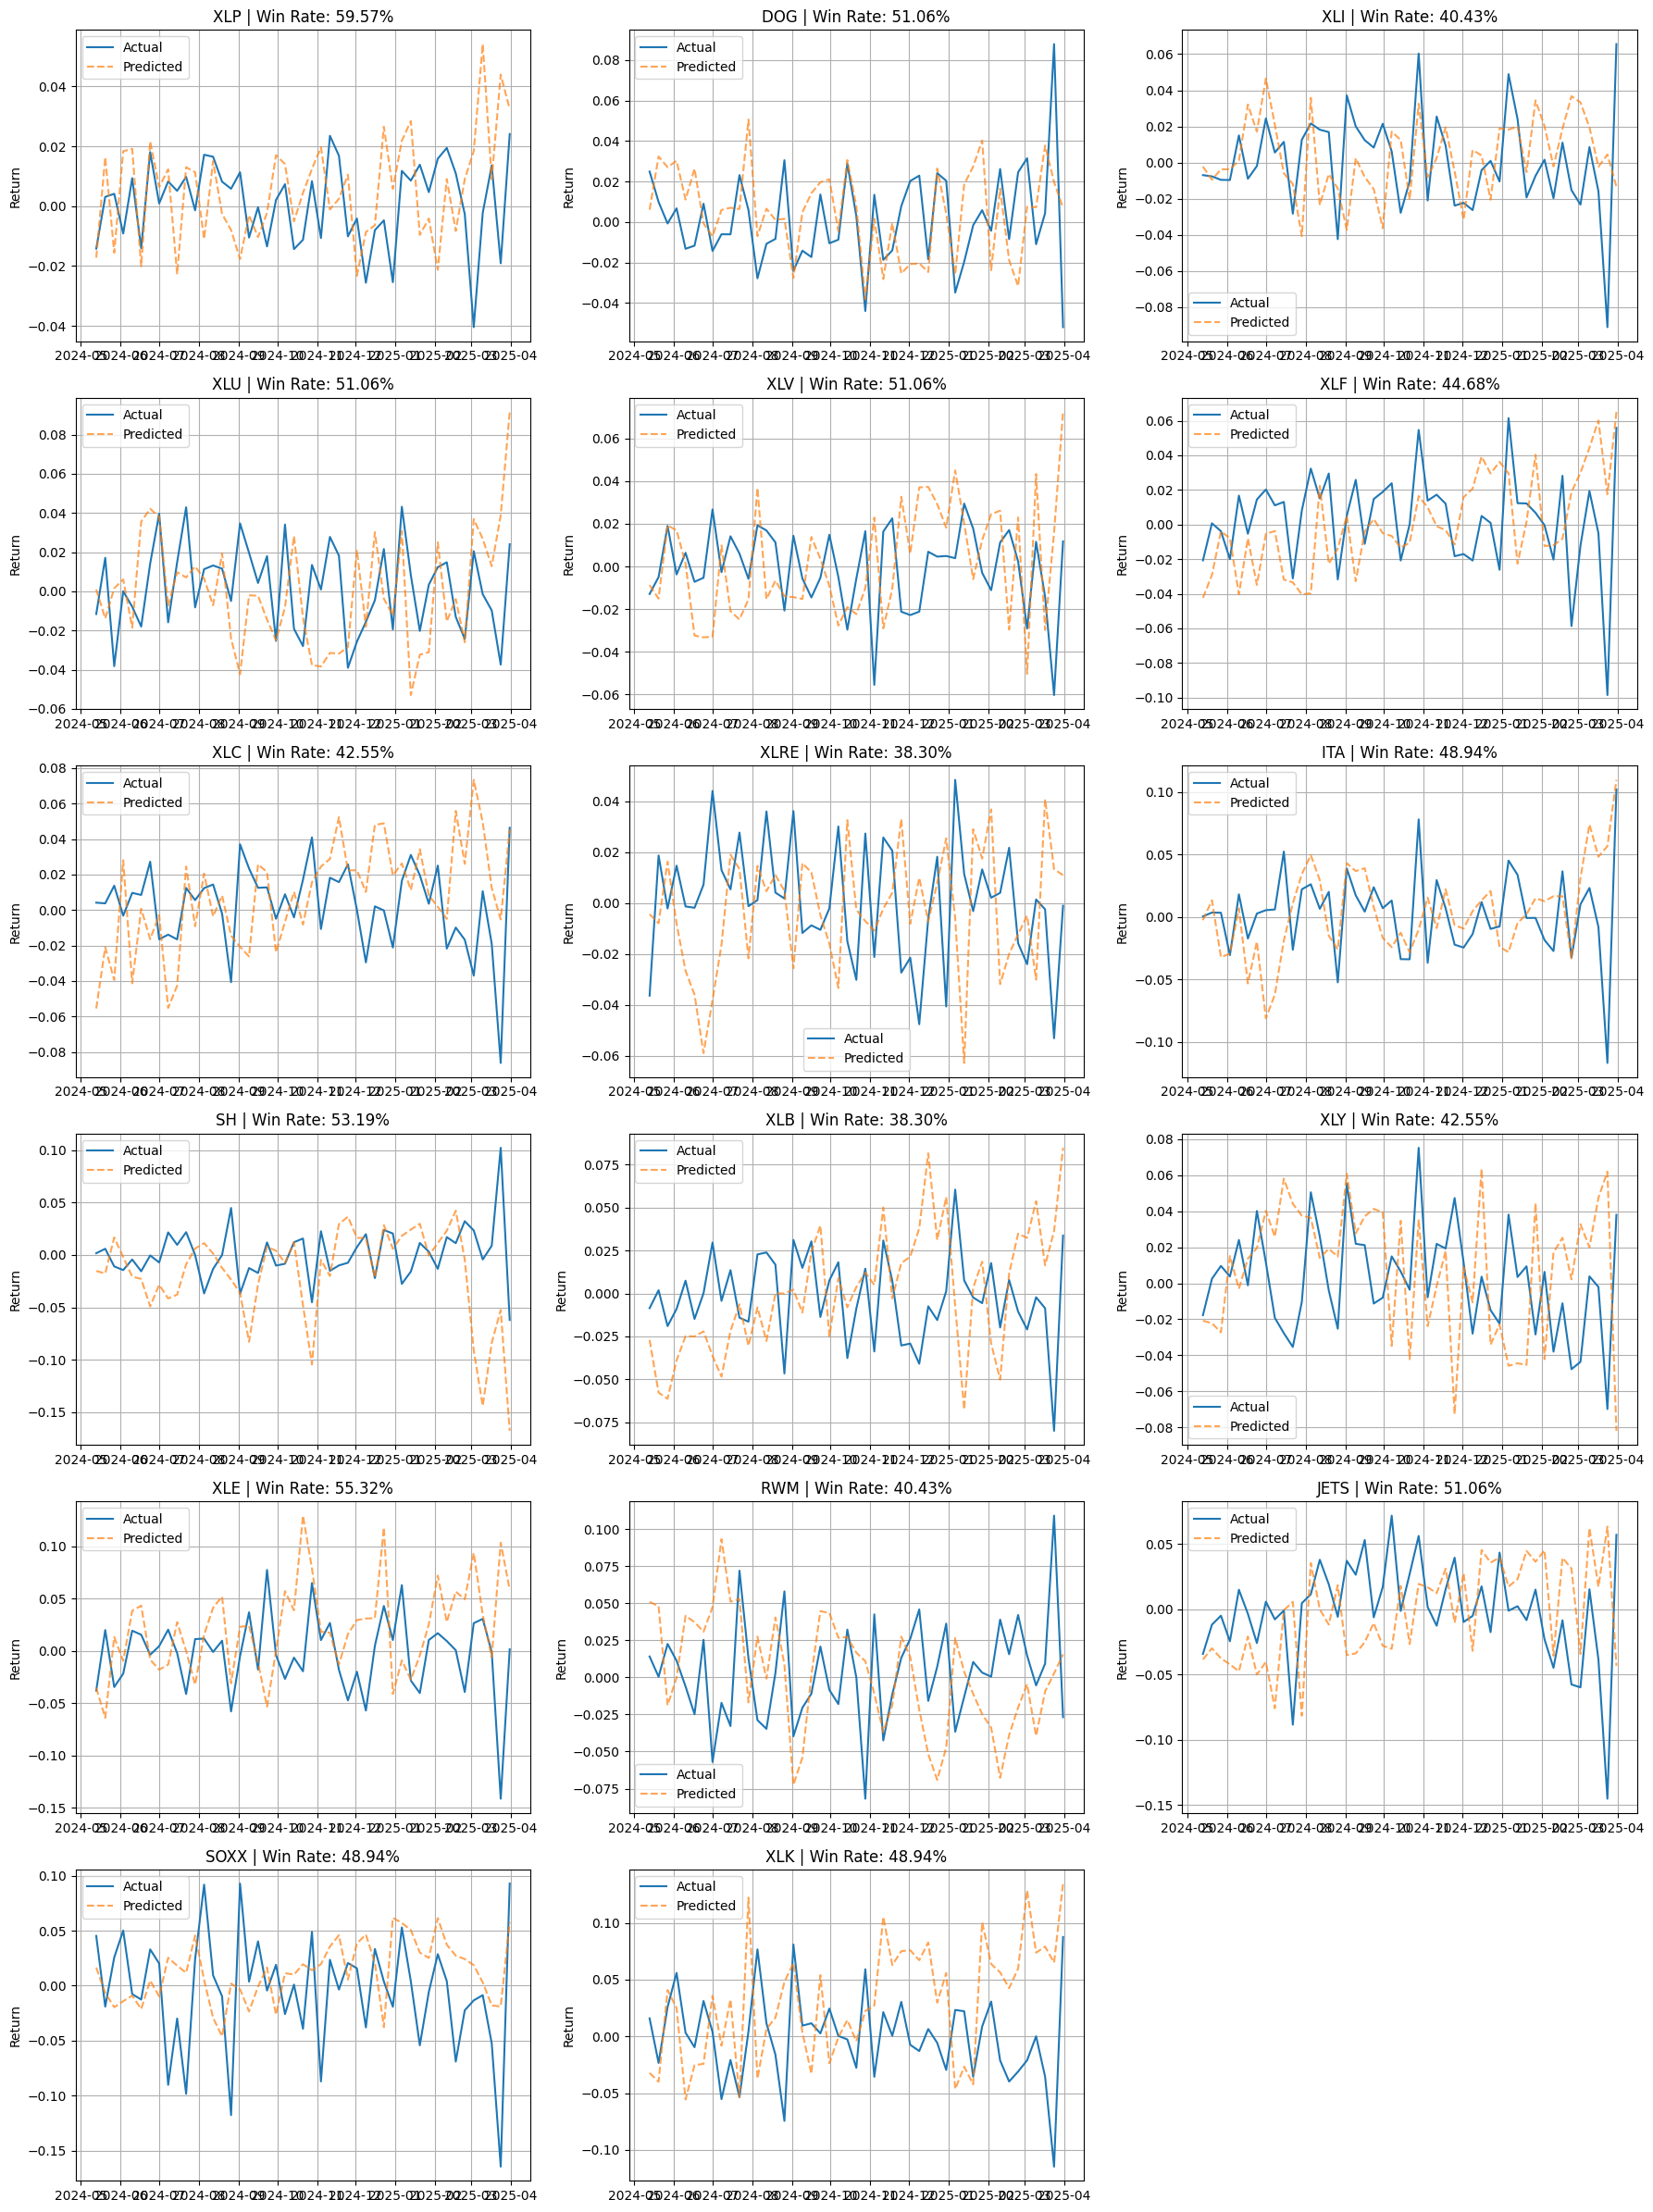

In [396]:
import matplotlib.pyplot as plt
import numpy as np

# === Plot averaged predictions ===
ncols = 3
nrows = -(-len(avg_df) // ncols)  # Ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows), sharex=False)
axes = axes.flatten()

for i, etf in enumerate(avg_df['ETF']):
    etf_data = averaged_test_df[averaged_test_df['ETF'] == etf]
    if etf_data.empty or 'Predicted' not in etf_data.columns:
        continue

    axes[i].plot(etf_data['Date'], etf_data['Target_Next_Week_Return'], label='Actual', linewidth=1.5)
    axes[i].plot(etf_data['Date'], etf_data['Predicted'], label='Predicted', alpha=0.7, linestyle='--')
    
    winrate = etf_data['Correct_Direction'].mean()
    axes[i].set_title(f"{etf} | Win Rate: {winrate:.2%}")
    axes[i].set_ylabel("Return")
    axes[i].legend()
    axes[i].grid(True)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
averaged_test_df.to_csv("../dataset/averaged_test_df.csv", index=False)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# === Load latest data ===
feature_df = pd.read_csv("../dataset/etf_features.csv")
feature_df["Date"] = pd.to_datetime(feature_df["Date"], errors="coerce")
feature_df = feature_df.sort_values("Date")

# Use 2nd-to-last date to simulate past prediction
last_two_dates = feature_df["Date"].drop_duplicates().sort_values().unique()[-2:]
predict_date = last_two_dates[0]
evaluate_date = last_two_dates[1]

print(f"🧪 Predicting from {predict_date.date()} → evaluating on {evaluate_date.date()}")

latest_rows = feature_df[feature_df["Date"] == predict_date].copy().set_index("ETF")
actual_returns = feature_df[feature_df["Date"] == evaluate_date][["ETF", "Target_Next_Week_Return"]].set_index("ETF")

recommendations = []

for etf in latest_rows.index:
    try:
        row = latest_rows.loc[etf]
        X = row[features].values.reshape(1, -1)

        # === Scale ===
        scaler = StandardScaler()
        scaler.fit(feature_df[features])
        X_scaled = scaler.transform(X)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        # === Load top-5 average weights ===
        snapshots = performance_snapshots[etf]
        for i, snap in enumerate(snapshots):
            snap["weights"] = weight_snapshots[etf][i]
        avg_weights = average_top_k_weights_by_win(snapshots, k=5)

        model = TrendAmplifyModel(input_dim=len(features)).to(device)
        model.load_state_dict(avg_weights)
        model.eval()

        with torch.no_grad():
            d_out, m_out = model(X_tensor.to(device))
            direction = (d_out > 0.5).float() * 2 - 1
            predicted_return = float((direction * m_out).cpu().item())
            confidence = float(d_out.cpu().item())

        actual_return = actual_returns.loc[etf, "Target_Next_Week_Return"] if etf in actual_returns.index else np.nan

        recommendations.append({
            "ETF": etf,
            "Predicted Return": round(predicted_return, 5),
            "Confidence": round(confidence, 5),
            "Actual Return": round(actual_return, 5) if not pd.isna(actual_return) else "N/A",
        })

    except Exception as e:
        print(f"⚠️ {etf} skipped due to error: {e}")

# === Show Results ===
reco_df = pd.DataFrame(recommendations).sort_values("Predicted Return", ascending=False)
from IPython.display import display
display(reco_df)


🧪 Predicting from 2025-03-24 → evaluating on 2025-03-31
⚠️ XLI skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ SOXX skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ XLV skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight

c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fit

KeyError: 'Predicted Return'

: 

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# === Setup ===
prediction_date = pd.Timestamp.today().strftime("%Y-%m-%d")
csv_name = f"../dataset/weekly_predictions_{prediction_date.replace('-', '')}.csv"

# === Prepare data ===
latest_rows = feature_df.sort_values("Date").groupby("ETF").tail(1).copy().set_index("ETF")
recommendations = []

for etf in latest_rows.index:
    try:
        row = latest_rows.loc[etf]
        X = row[features].values.reshape(1, -1)

        # Scale using historical data for that ETF
        etf_hist = feature_df[feature_df["ETF"] == etf]
        scaler = StandardScaler()
        scaler.fit(etf_hist[features])
        X_scaled = scaler.transform(X)

        # Predict
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
        model = TrendAmplifyModel(input_dim=len(features)).to(device)
        model.load_state_dict(weight_snapshots[etf][-1])  # use latest trained weights
        model.eval()

        with torch.no_grad():
            out_cls, out_mag = model(X_tensor)
            predicted_return = float(((out_cls > 0.5).float() * 2 - 1) * out_mag).item()
            confidence = float(out_cls.cpu().item())

        # Clamp
        predicted_return = np.clip(predicted_return, -0.15, 0.15)
        confidence = np.clip(confidence, 0.0, 1.0)

        # Historical win rate (52w)
        past = test_df[test_df['ETF'] == etf].sort_values('Date').tail(52)
        if not past.empty:
            past_win_rate = (np.sign(past['Predicted']) == np.sign(past['Target_Next_Week_Return'])).mean()
        else:
            past_win_rate = 0.5

        # Composite score
        score = predicted_return * confidence * past_win_rate

        # Target & Stop Loss
        last_price = price_df[etf].dropna().iloc[-1]
        recent_std = price_df[etf].pct_change().dropna().tail(20).std()
        target_price = last_price * (1 + predicted_return)
        stop_loss = last_price * (1 - 2 * recent_std) if predicted_return > 0 else last_price * (1 + predicted_return - 1.5 * recent_std)
        stop_loss = min(stop_loss, last_price * 0.98)

        # Edge flag from feature_df
        edge_flag = bool(row['Edge_Flag']) if 'Edge_Flag' in row else False

        recommendations.append({
            "Prediction_Date": prediction_date,
            "ETF": etf,
            "Score (R×C×WinRate)": round(score, 5),
            "Predicted Return": round(predicted_return, 5),
            "Confidence": round(confidence, 5),
            "Win Rate (52w)": round(past_win_rate, 4),
            "Edge_Flag": edge_flag,
            "Current Price": round(last_price, 2),
            "Target Sell High": round(target_price, 2),
            "Stop Loss Price": round(stop_loss, 2)
        })

    except Exception as e:
        print(f"⚠️ {etf} skipped due to error: {e}")

# === Save & Show
reco_df = pd.DataFrame(recommendations)
if not reco_df.empty:
    reco_df = reco_df.sort_values("Score (R×C×WinRate)", ascending=False)

reco_df.to_csv(csv_name, index=False)
print(f"✅ Saved predictions to {csv_name}")

from IPython.display import display
display(reco_df)


⚠️ XLU skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ XLC skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ DOG skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ XLF skipped due to error: Error

c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fit

Empty DataFrame
Columns: []
Index: []

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# === Setup ===
prediction_date = pd.Timestamp.today().strftime("%Y-%m-%d")
csv_name = f"../dataset/weekly_predictions_{prediction_date.replace('-', '')}.csv"

# === Prepare data ===
latest_rows = feature_df.sort_values("Date").groupby("ETF").tail(1).copy().set_index("ETF")
recommendations = []

for etf in latest_rows.index:
    try:
        row = latest_rows.loc[etf]
        X = row[features].values.reshape(1, -1)

        # Scale using historical data for that ETF
        etf_hist = feature_df[feature_df["ETF"] == etf]
        scaler = StandardScaler()
        scaler.fit(etf_hist[features])
        X_scaled = scaler.transform(X)

        # Predict
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
        model = TrendAmplifyModel(input_dim=len(features)).to(device)
        model.load_state_dict(weight_snapshots[etf][-1])  # use latest trained weights
        model.eval()

        with torch.no_grad():
            out_cls, out_mag = model(X_tensor)
            predicted_return = float(((out_cls > 0.5).float() * 2 - 1) * out_mag).item()
            confidence = float(out_cls.cpu().item())

        # Clamp
        predicted_return = np.clip(predicted_return, -0.15, 0.15)
        confidence = np.clip(confidence, 0.0, 1.0)

        # Historical win rate (52w)
        past = test_df[test_df['ETF'] == etf].sort_values('Date').tail(52)
        if not past.empty:
            past_win_rate = (np.sign(past['Predicted']) == np.sign(past['Target_Next_Week_Return'])).mean()
        else:
            past_win_rate = 0.5

        # Composite score
        score = predicted_return * confidence * past_win_rate

        # Target & Stop Loss
        last_price = price_df[etf].dropna().iloc[-1]
        recent_std = price_df[etf].pct_change().dropna().tail(20).std()
        target_price = last_price * (1 + predicted_return)
        stop_loss = last_price * (1 - 2 * recent_std) if predicted_return > 0 else last_price * (1 + predicted_return - 1.5 * recent_std)
        stop_loss = min(stop_loss, last_price * 0.98)

        # Edge flag from feature_df
        edge_flag = bool(row['Edge_Flag']) if 'Edge_Flag' in row else False

        recommendations.append({
            "Prediction_Date": prediction_date,
            "ETF": etf,
            "Score (R×C×WinRate)": round(score, 5),
            "Predicted Return": round(predicted_return, 5),
            "Confidence": round(confidence, 5),
            "Win Rate (52w)": round(past_win_rate, 4),
            "Edge_Flag": edge_flag,
            "Current Price": round(last_price, 2),
            "Target Sell High": round(target_price, 2),
            "Stop Loss Price": round(stop_loss, 2)
        })

    except Exception as e:
        print(f"⚠️ {etf} skipped due to error: {e}")

# === Save & Show
reco_df = pd.DataFrame(recommendations)
if not reco_df.empty:
    reco_df = reco_df.sort_values("Score (R×C×WinRate)", ascending=False)

reco_df.to_csv(csv_name, index=False)
print(f"✅ Saved predictions to {csv_name}")

from IPython.display import display
display(reco_df)


⚠️ XLU skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ XLC skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ DOG skipped due to error: Error(s) in loading state_dict for TrendAmplifyModel:
	Missing key(s) in state_dict: "return_head.0.weight", "return_head.0.bias", "return_head.2.weight", "return_head.2.bias". 
	Unexpected key(s) in state_dict: "mag_head.0.weight", "mag_head.0.bias", "mag_head.2.weight", "mag_head.2.bias". 
⚠️ XLF skipped due to error: Error

c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fit

Empty DataFrame
Columns: []
Index: []